# Healthcare Capstone Project

## Problem Statement: 

                Evanston Hospital is a comprehensive acute-care facility in Illinois, US. The hospital offers a wide range of services and surgical specialities, in addition to having high-end lab capabilities. Despite spending a considerable amount of resources on improving its services, the hospital’s CMS rating has remained at 3 for the past 5 years, and this has led to a steady decline in revenue for the hospital. For hospitals like Evanston, these ratings directly influence the choice made by consumers who are looking for a healthcare provider and would, therefore, have a significant impact on the hospitals’ revenues. As a consulting company hired by Evanston, our task is to identify possible root causes for the hospital getting such an average rating and recommend measures to mitigate this problem.

#### Solution Methodology :
- Identify potential root causes for the issues using Issue tree framework
  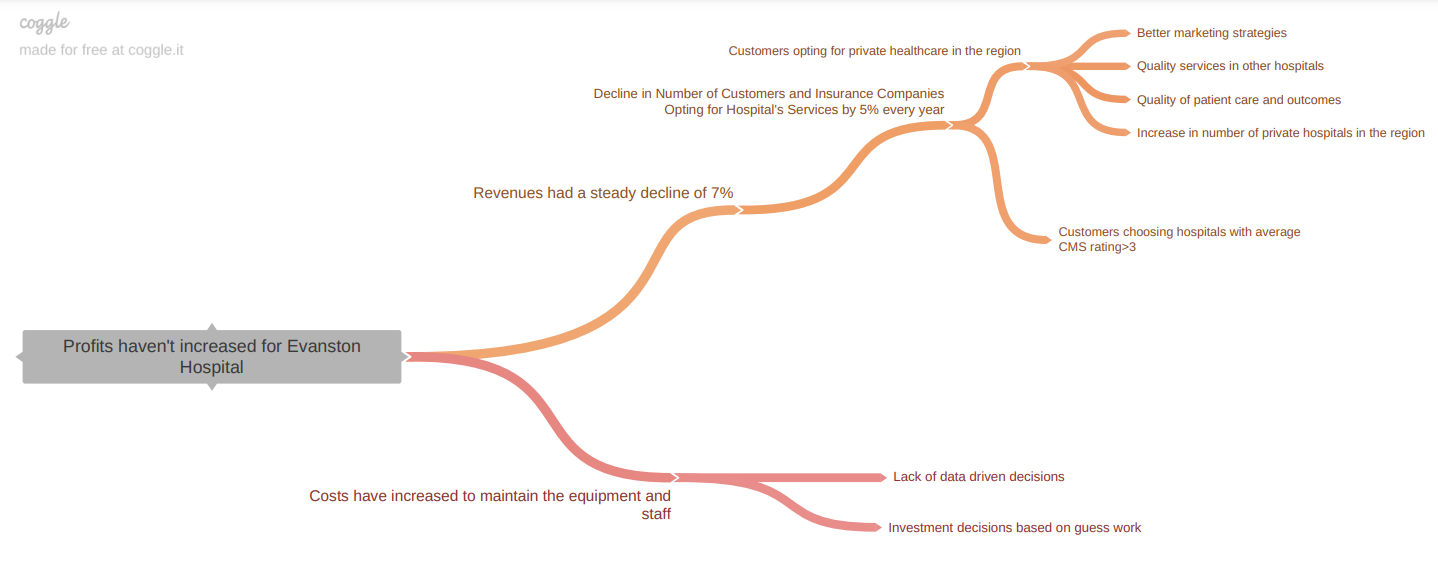
- Build a rating prediction model of past hospital data as a proof of concept

#### Steps taken :
- Understanding the data, cleaning it and preparing it for further analysis
- Performing univariate/bivariate analysis and feature engineering- 
Training different machine learning models on the data
Choosing and evaluating the model that provides the best metrics
Data storytelling using the insights and modelling results, and proposing a business solution

In [1]:
# Import libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

import warnings

warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.options.display.max_rows = 999

%matplotlib inline

# Data Preprocessing


In [2]:
#Convert columns to lower case and update not available values to nan
def df_prep(df, col):
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("(", "")
        .str.replace(")", "")
    )
    df.replace("Not Available", np.nan, inplace=True)
    return df

#Pivot the data frame and convert score to float
def pivot_df(df, substrings):
    df[pd.notnull(df["measure_id"])]
    df.drop_duplicates(keep="first", inplace=True)
    df = df[df["measure_id"].isin(substrings)]
    df["score"] = df["score"].astype(float)
    return df.pivot(index="provider_id", columns="measure_id", values="score")

#Function to merge the dfs
def distinct_merge(master_df, df):
    temp_df = pd.merge(master_df, df, on="provider_id", how="outer")
    return temp_df[temp_df["hospital_overall_rating"] != "Not Available"].dropna(
        subset=["hospital_overall_rating"]
    )

#Function to check the quality of data
def quality_check(
    df,
    unique_columns=["provider_id"],  # Default value changed to None
):
    """
    Perform a quality check on the DataFrame after a merge.

    Parameters:
    - df (pd.DataFrame): The DataFrame to check.
    - unique_columns (list of str, optional): List of columns that should be unique.

    Returns:
    - None: Prints the results of the quality checks.
    """

    if unique_columns is None:
        unique_columns = []  # Set to empty list if not provided

    # Check for duplicates in unique columns
    if unique_columns:
        for col in unique_columns:
            if col in df.columns:
                assert df[col].is_unique, f"Column '{col}' is not unique"
            else:
                print(f"Warning: Column '{col}' is not in the DataFrame")

    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("Warning: Missing values found:")
        print(missing_values[missing_values > 0])

    print("Quality check Done.")

# Hospital General Information

In [3]:
df_hgi = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Hospital General Information.csv",encoding='windows-1252')
df_hgi = df_prep(df_hgi,"score")

In [4]:
columns_to_drop = [col for col in df_hgi.columns if col.endswith("footnote")]

# Drop the identified columns
df_hgi.drop(columns=columns_to_drop, inplace=True)

In [5]:
df_hgi.head(3)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,hospital_type,hospital_ownership,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,Same as the National average,Above the National average,Same as the National average,Below the National average,Same as the National average,Same as the National average,Same as the National average
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,3,Below the National average,Same as the National average,Above the National average,Same as the National average,Same as the National average,Above the National average,Below the National average
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,Acute Care Hospitals,Government - Hospital District or Authority,Yes,Y,2,Below the National average,Same as the National average,Same as the National average,Below the National average,Same as the National average,Above the National average,Same as the National average


replace catagorical values with numerical values

In [6]:
replacement_dict = {
    "Same as the National average": 0,
    "Below the National average": -1,
    "Above the National average": 1,
    "Not Available": None,
}
comparison_columns = [col for col in df_hgi.columns if col.endswith("comparison")]

for col in comparison_columns:
    df_hgi[col] = df_hgi[col].replace(replacement_dict)
Hospital_rating = df_hgi.drop(
    df_hgi[df_hgi["hospital_overall_rating"] == "Not Available"].index
)
Hospital_rating["hospital_overall_rating"].unique()

array(['3', '2', nan, '4', '5', '1'], dtype=object)

In [7]:
# Drop columns from master dataset that are not needed for analysis

dropcols = [
    "hospital_name",
    "address",
    "city",   
    "state",
    "zip_code",
    "county_name",
    "phone_number",
    "hospital_type",
    "hospital_ownership",
]

df_hgi = df_hgi.drop(dropcols, axis=1)

Check uniquniess at Provider ID

In [8]:
# Check for duplicates in provider_id
duplicates = df_hgi["provider_id"].duplicated().any()
print(f"Are there any duplicate provider_id values in df_hgi? {duplicates}")

# Check if the number of unique provider_id values equals the number of rows
unique_count = df_hgi["provider_id"].nunique()
total_count = len(df_hgi)
print(f"Number of unique provider_id values in df_hgi: {unique_count}")
print(f"Total number of rows in df_hgi: {total_count}")

if unique_count == total_count:
    print("All provider_id values in df_hgi are unique.")
else:
    print("There are duplicate provider_id values in df_hgi.")

Are there any duplicate provider_id values in df_hgi? False
Number of unique provider_id values in df_hgi: 4818
Total number of rows in df_hgi: 4818
All provider_id values in df_hgi are unique.


Checking missing data after each merging 

In [9]:
df_hgi.head(3)

,provider_id,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison
0,10001,Yes,Y,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0
1,10005,Yes,Y,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0
2,10006,Yes,Y,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0


In [10]:
# Perform the quality check
quality_check(df_hgi, ["provider_id"])

meets_criteria_for_meaningful_use_of_ehrs                435
hospital_overall_rating                                 1170
mortality_national_comparison                           1337
safety_of_care_national_comparison                      1892
readmission_national_comparison                         1002
patient_experience_national_comparison                  1355
effectiveness_of_care_national_comparison               1116
timeliness_of_care_national_comparison                  1331
efficient_use_of_medical_imaging_national_comparison    2026
dtype: int64
Quality check Done.


# Readmissions and Deaths

In [11]:
df_rd = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Readmissions and Deaths - Hospital.csv",encoding='windows-1252')
df_rd = df_prep(df_rd,"score")
df_rd.head(3)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_name,measure_id,compared_to_national,denominator,score,lower_estimate,higher_estimate,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015


In [12]:
df_rd["measure_id"].unique()

array(['MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF',
       'MORT_30_PN', 'MORT_30_STK', 'READM_30_AMI', 'READM_30_CABG',
       'READM_30_COPD', 'READM_30_HF', 'READM_30_HIP_KNEE',
       'READM_30_HOSP_WIDE', 'READM_30_PN', 'READM_30_STK'], dtype=object)

In [13]:
df_rd.head(3)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_name,measure_id,compared_to_national,denominator,score,lower_estimate,higher_estimate,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015


In [14]:
df_rd = pivot_df(df_rd,['MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF',
       'MORT_30_PN', 'MORT_30_STK', 'READM_30_AMI', 'READM_30_CABG',
       'READM_30_COPD', 'READM_30_HF', 'READM_30_HIP_KNEE',
       'READM_30_HOSP_WIDE', 'READM_30_PN', 'READM_30_STK'])
#df_rd = pd.merge(df_rd_pivot, df_rd[['provider_id','compared_to_national']].drop_duplicates(), on = 'provider_id')
df_rd.head()


measure_id,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_AMI,READM_30_CABG,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK
provider_id,,,,,,,,,,,,,,
10001,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,9.3,14.4,18.8,16.6,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,8.2,12.7,15.7,NaN,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN


In [15]:
base_df = distinct_merge(df_hgi, df_rd)
base_df["hospital_overall_rating"].unique()

base_df.shape

(3648, 25)

In [16]:
base_df.head(5)

,provider_id,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_AMI,READM_30_CABG,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK
0,10001,Yes,Y,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
1,10005,Yes,Y,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
2,10006,Yes,Y,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
3,10007,Yes,Y,3,0.0,0.0,-1.0,0.0,0.0,1.0,NaN,NaN,NaN,9.3,14.4,18.8,16.6,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
4,10008,Yes,Y,3,0.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN,8.2,12.7,15.7,NaN,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN


# Healthcare Associated Infections

In [17]:
df_hai = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Healthcare Associated Infections - Hospital.csv",encoding='windows-1252')
df_hai = df_prep(df_hai,"score")
df_hai.head(3)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,measure_name,measure_id,compared_to_national,score,footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Lower Confidence Limit,HAI_1_CI_LOWER,NaN,1.03,NaN,1/1/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Upper Confidence Limit,HAI_1_CI_UPPER,NaN,2.765,NaN,1/1/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,CLABSI: Number of Device Days,HAI_1_DOPC_DAYS,NaN,7117,NaN,1/1/2015,12/31/2015


In [18]:
df_hai["measure_id"].unique()

array(['HAI_1_CI_LOWER', 'HAI_1_CI_UPPER', 'HAI_1_DOPC_DAYS',
       'HAI_1_ELIGCASES', 'HAI_1_NUMERATOR', 'HAI_1_SIR',
       'HAI_1a_CI_LOWER', 'HAI_1a_CI_UPPER', 'HAI_1a_DOPC_DAYS',
       'HAI_1a_ELIGCASES', 'HAI_1a_NUMERATOR', 'HAI_1a_SIR',
       'HAI_2_CI_LOWER', 'HAI_2_CI_UPPER', 'HAI_2_DOPC_DAYS',
       'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR',
       'HAI_2a_CI_LOWER', 'HAI_2a_CI_UPPER', 'HAI_2a_DOPC_DAYS',
       'HAI_2a_ELIGCASES', 'HAI_2a_NUMERATOR', 'HAI_2a_SIR',
       'HAI_3_CI_LOWER', 'HAI_3_CI_UPPER', 'HAI_3_DOPC_DAYS',
       'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR',
       'HAI_4_CI_LOWER', 'HAI_4_CI_UPPER', 'HAI_4_DOPC_DAYS',
       'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR',
       'HAI_5_CI_LOWER', 'HAI_5_CI_UPPER', 'HAI_5_DOPC_DAYS',
       'HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR',
       'HAI_6_CI_LOWER', 'HAI_6_CI_UPPER', 'HAI_6_DOPC_DAYS',
       'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR', 'HAI_6_SIR'], dtype=object)

In [19]:
col_to_keep = [ 'HAI_1_DOPC_DAYS',
       'HAI_1_ELIGCASES', 'HAI_1_NUMERATOR', 'HAI_1_SIR', 'HAI_1a_DOPC_DAYS',
       'HAI_1a_ELIGCASES', 'HAI_1a_NUMERATOR', 'HAI_1a_SIR', 'HAI_2_DOPC_DAYS',
       'HAI_2_ELIGCASES', 'HAI_2_NUMERATOR', 'HAI_2_SIR', 'HAI_2a_DOPC_DAYS',
       'HAI_2a_ELIGCASES', 'HAI_2a_NUMERATOR', 'HAI_2a_SIR', 'HAI_3_DOPC_DAYS',
       'HAI_3_ELIGCASES', 'HAI_3_NUMERATOR', 'HAI_3_SIR','HAI_4_DOPC_DAYS',
       'HAI_4_ELIGCASES', 'HAI_4_NUMERATOR', 'HAI_4_SIR', 'HAI_5_DOPC_DAYS',
       'HAI_5_ELIGCASES', 'HAI_5_NUMERATOR', 'HAI_5_SIR','HAI_6_DOPC_DAYS',
       'HAI_6_ELIGCASES', 'HAI_6_NUMERATOR', 'HAI_6_SIR']
df_hai = pivot_df(df_hai, col_to_keep)
df_hai.head()

base_df = distinct_merge(base_df, df_hai)
base_df["hospital_overall_rating"].unique()
base_df.shape

(3648, 57)

In [20]:
quality_check(base_df)

meets_criteria_for_meaningful_use_of_ehrs                196
mortality_national_comparison                            285
safety_of_care_national_comparison                       743
readmission_national_comparison                          124
patient_experience_national_comparison                   273
effectiveness_of_care_national_comparison                205
timeliness_of_care_national_comparison                   355
efficient_use_of_medical_imaging_national_comparison     894
MORT_30_AMI                                             1267
MORT_30_CABG                                            2612
MORT_30_COPD                                             257
MORT_30_HF                                               221
MORT_30_PN                                               131
MORT_30_STK                                              984
READM_30_AMI                                            1490
READM_30_CABG                                           2623
READM_30_COPD           

In [21]:
base_df.head(3)

,provider_id,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_AMI,READM_30_CABG,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,HAI_1_DOPC_DAYS,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_1a_DOPC_DAYS,HAI_1a_ELIGCASES,HAI_1a_NUMERATOR,HAI_1a_SIR,HAI_2_DOPC_DAYS,HAI_2_ELIGCASES,HAI_2_NUMERATOR,HAI_2_SIR,HAI_2a_DOPC_DAYS,HAI_2a_ELIGCASES,HAI_2a_NUMERATOR,HAI_2a_SIR,HAI_3_DOPC_DAYS,HAI_3_ELIGCASES,HAI_3_NUMERATOR,HAI_3_SIR,HAI_4_DOPC_DAYS,HAI_4_ELIGCASES,HAI_4_NUMERATOR,HAI_4_SIR,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR
0,10001,Yes,Y,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7,7117.0,9.198,16.0,1.740,2191.0,3.288,8.0,2.433,14326.0,20.321,29.0,1.427,6502.0,7.803,18.0,2.307,156.0,5.347,10.0,1.870,154.0,1.721,0.0,0.0,83773.0,7.111,3.0,0.422,81130.0,47.018,37.0,0.787
1,10005,Yes,Y,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4,2786.0,3.767,4.0,1.062,1028.0,1.543,1.0,0.648,7368.0,10.965,5.0,0.456,3305.0,4.297,3.0,0.698,74.0,2.594,1.0,0.386,43.0,0.454,0.0,NaN,36123.0,1.441,2.0,1.388,36262.0,17.293,7.0,0.405
2,10006,Yes,Y,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0,11159.0,17.577,6.0,0.341,5377.0,9.038,4.0,0.443,13235.0,23.383,15.0,0.641,7399.0,12.488,10.0,0.801,93.0,3.226,1.0,0.310,55.0,0.679,2.0,NaN,64858.0,3.173,4.0,1.261,62157.0,33.115,17.0,0.513


# HCAHPS - Hospital

In [22]:
df_hps = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\HCAHPS - Hospital.csv",encoding='windows-1252')
df_hps = df_prep(df_hps, "hcahps_linear_mean_value")
df_hps.head(3)

,provider_id,hospital_name,address,city,state,zip_code,county_name,phone_number,hcahps_measure_id,hcahps_question,hcahps_answer_description,patient_survey_star_rating,patient_survey_star_rating_footnote,hcahps_answer_percent,hcahps_answer_percent_footnote,hcahps_linear_mean_value,number_of_completed_surveys,number_of_completed_surveys_footnote,survey_response_rate_percent,survey_response_rate_percent_footnote,measure_start_date,measure_end_date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_STAR_RATING,Summary star rating,Summary star rating,3,NaN,Not Applicable,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_A_P,Patients who reported that their room and bath...,"Room was ""always"" clean",Not Applicable,NaN,66,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,H_CLEAN_HSP_SN_P,Patients who reported that their room and bath...,"Room was ""sometimes"" or ""never"" clean",Not Applicable,NaN,12,NaN,Not Applicable,1194,NaN,27,NaN,01/01/2015,12/31/2015


In [23]:
df_hps["hcahps_measure_id"].unique()

array(['H_STAR_RATING', 'H_CLEAN_HSP_A_P', 'H_CLEAN_HSP_SN_P',
       'H_CLEAN_HSP_U_P', 'H_CLEAN_LINEAR_SCORE', 'H_CLEAN_STAR_RATING',
       'H_COMP_1_A_P', 'H_COMP_1_LINEAR_SCORE', 'H_COMP_1_SN_P',
       'H_COMP_1_STAR_RATING', 'H_COMP_1_U_P', 'H_COMP_2_A_P',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_2_SN_P', 'H_COMP_2_STAR_RATING',
       'H_COMP_2_U_P', 'H_COMP_3_A_P', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_3_SN_P', 'H_COMP_3_STAR_RATING', 'H_COMP_3_U_P',
       'H_COMP_4_A_P', 'H_COMP_4_LINEAR_SCORE', 'H_COMP_4_SN_P',
       'H_COMP_4_STAR_RATING', 'H_COMP_4_U_P', 'H_COMP_5_A_P',
       'H_COMP_5_LINEAR_SCORE', 'H_COMP_5_SN_P', 'H_COMP_5_STAR_RATING',
       'H_COMP_5_U_P', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_6_N_P',
       'H_COMP_6_STAR_RATING', 'H_COMP_6_Y_P', 'H_COMP_7_A',
       'H_COMP_7_D_SD', 'H_COMP_7_LINEAR_SCORE', 'H_COMP_7_SA',
       'H_COMP_7_STAR_RATING', 'H_HSP_RATING_0_6', 'H_HSP_RATING_7_8',
       'H_HSP_RATING_9_10', 'H_HSP_RATING_LINEAR_SCORE',
       'H_HSP_RAT

In [24]:
col_to_keep = [
    "H_CLEAN_LINEAR_SCORE",
    "H_COMP_1_LINEAR_SCORE",
    "H_COMP_2_LINEAR_SCORE",
    "H_COMP_3_LINEAR_SCORE",
    "H_COMP_4_LINEAR_SCORE",
    "H_COMP_5_LINEAR_SCORE",
    "H_COMP_6_LINEAR_SCORE",
    "H_COMP_7_LINEAR_SCORE",
    "H_HSP_RATING_LINEAR_SCORE",
    "H_QUIET_LINEAR_SCORE",
    "H_RECMND_LINEAR_SCORE",
]
df_hps.rename(
    columns={"hcahps_measure_id": "measure_id", "hcahps_linear_mean_value": "score"},
    inplace=True,
)
df_hps = pivot_df(df_hps, col_to_keep)
base_df = distinct_merge(base_df, df_hps)
base_df["hospital_overall_rating"].unique()
base_df.shape


(3648, 68)

In [25]:
base_df_cleaned.head()

NameError: name 'base_df_cleaned' is not defined

In [ ]:
quality_check(base_df)

# Timely And Effective Care

In [ ]:
df_time = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Timely and Effective Care - Hospital.csv",encoding='windows-1252')
df_time = df_prep(df_time,"Score")
df_time.head(3)

In [ ]:
df_time["measure_id"].unique()

In [ ]:
# Replacing EDV values to numeric
df_time['score'] = df_time['score'].replace({
    'Low (0 - 19,999 patients annually)': 1, 
    'Medium (20,000 - 39,999 patients annually)': 2,
    'High (40,000 - 59,999 patients annually)': 3,
    'Very High (60,000+ patients annually)': 4
})


In [ ]:
col_to_keep = [ 'ED_1b', 'ED_2b', 'EDV', 'HF_2',
       'IMM_2', 'IMM_3_OP_27_FAC_ADHPCT', 'OP_1', 'OP_18b', 'OP_2',
       'OP_20', 'OP_21', 'OP_22', 'OP_23', 'OP_29', 'OP_30', 'OP_3b',
       'OP_4', 'OP_5', 'PC_01','EDV','SCIP_CARD_2', 'SCIP_INF_1',
       'SCIP_INF_2', 'SCIP_INF_3', 'SCIP_INF_9', 'SCIP_VTE_2', 'STK_1',
       'STK_10', 'STK_2', 'STK_3', 'STK_4', 'STK_5', 'STK_6', 'STK_8',
       'VTE_1', 'VTE_2', 'VTE_3', 'VTE_4', 'VTE_5', 'VTE_6'
]
df_time = pivot_df(df_time, col_to_keep)
base_df = distinct_merge(base_df, df_time)
#base_df["hospital_overall_rating"].unique()
base_df.head(5)

In [ ]:
base_df['EDV'].value_counts()

# Payment and Value of Care

In [ ]:
df_pvc = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Payment and Value of Care - Hospital.csv",encoding='windows-1252')
df_pvc.head(3)

In [ ]:
#Remove records with Not available data
df_pvc = df_pvc[~(df_pvc['Denominator']=='Not Available')]

# Convert Denominator, Payment, Lower estimate, Higher estimate to numeric, handling non-numeric values
columns_to_numeric = ['Denominator', 'Payment', 'Lower estimate', 'Higher estimate']
for column in columns_to_numeric:
    df_pvc[column] = df_pvc[column].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
    
#Convert $ values to K$ as it is K$ in other sheets
df_pvc['Payment'] = df_pvc['Payment']/1000
df_pvc['Lower estimate'] = df_pvc['Lower estimate']/1000
df_pvc['Higher estimate'] = df_pvc['Higher estimate']/1000
df_pvc = df_prep(df_pvc,"Payment")

In [ ]:
df_pvc.head()

In [ ]:
df_pvc['payment_measure_id'].unique()

In [ ]:
col_to_keep = ['PAYM_30_HF', 'PAYM_30_PN', 'PAYM_30_AMI'
]
df_pvc.rename(
    columns={"payment_measure_id": "measure_id", "payment": "score"},
    inplace=True,
)
df_pvc = pivot_df(df_pvc, col_to_keep)
base_df = distinct_merge(base_df, df_pvc)
#base_df["hospital_overall_rating"].unique()
base_df.shape

In [ ]:
base_df.head()

# OutPatient Imaging Efficiency Hospital

In [ ]:
df_oie = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Outpatient Imaging Efficiency - Hospital.csv")

In [ ]:
df_oie.head(3)

In [ ]:
df_oie = df_prep(df_oie,"Score")
df_oie.head()

In [ ]:
df_oie['measure_id'].unique()

In [ ]:
col_to_keep = ['OP_10', 'OP_11', 'OP_13', 'OP_14', 'OP_8', 'OP_9']
df_oie = pivot_df(df_oie, col_to_keep)
base_df = distinct_merge(base_df, df_oie)
#base_df["hospital_overall_rating"].unique()
base_df.shape

In [ ]:
base_df.head(3)

# Complications Hospital

In [ ]:
df_com = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Complications - Hospital.csv",encoding='windows-1252')
df_com.head(3)

In [ ]:
df_com = df_prep(df_com,'Score')
df_com.head(3)

In [ ]:
df_com['measure_id'].unique()

In [ ]:
col_to_keep = ['COMP_HIP_KNEE', 'PSI_12_POSTOP_PULMEMB_DVT', 'PSI_13_POST_SEPSIS',
       'PSI_14_POSTOP_DEHIS', 'PSI_15_ACC_LAC', 'PSI_3_ULCER',
       'PSI_4_SURG_COMP', 'PSI_6_IAT_PTX', 'PSI_7_CVCBI',
       'PSI_8_POST_HIP', 'PSI_90_SAFETY']
df_com = pivot_df(df_com, col_to_keep)
base_df = distinct_merge(base_df, df_com)
#base_df["hospital_overall_rating"].unique()
base_df.shape

In [26]:
base_df.head(3)

,provider_id,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_AMI,READM_30_CABG,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,HAI_1_DOPC_DAYS,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_1a_DOPC_DAYS,HAI_1a_ELIGCASES,HAI_1a_NUMERATOR,HAI_1a_SIR,HAI_2_DOPC_DAYS,HAI_2_ELIGCASES,HAI_2_NUMERATOR,HAI_2_SIR,HAI_2a_DOPC_DAYS,HAI_2a_ELIGCASES,HAI_2a_NUMERATOR,HAI_2a_SIR,HAI_3_DOPC_DAYS,HAI_3_ELIGCASES,HAI_3_NUMERATOR,HAI_3_SIR,HAI_4_DOPC_DAYS,HAI_4_ELIGCASES,HAI_4_NUMERATOR,HAI_4_SIR,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR,H_CLEAN_LINEAR_SCORE,H_COMP_1_LINEAR_SCORE,H_COMP_2_LINEAR_SCORE,H_COMP_3_LINEAR_SCORE,H_COMP_4_LINEAR_SCORE,H_COMP_5_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,H_COMP_7_LINEAR_SCORE,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE
0,10001,Yes,Y,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7,7117.0,9.198,16.0,1.740,2191.0,3.288,8.0,2.433,14326.0,20.321,29.0,1.427,6502.0,7.803,18.0,2.307,156.0,5.347,10.0,1.870,154.0,1.721,0.0,0.0,83773.0,7.111,3.0,0.422,81130.0,47.018,37.0,0.787,84.0,90.0,92.0,80.0,86.0,77.0,87.0,82.0,89.0,88.0,90.0
1,10005,Yes,Y,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4,2786.0,3.767,4.0,1.062,1028.0,1.543,1.0,0.648,7368.0,10.965,5.0,0.456,3305.0,4.297,3.0,0.698,74.0,2.594,1.0,0.386,43.0,0.454,0.0,NaN,36123.0,1.441,2.0,1.388,36262.0,17.293,7.0,0.405,83.0,91.0,94.0,84.0,88.0,80.0,88.0,81.0,90.0,86.0,89.0
2,10006,Yes,Y,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0,11159.0,17.577,6.0,0.341,5377.0,9.038,4.0,0.443,13235.0,23.383,15.0,0.641,7399.0,12.488,10.0,0.801,93.0,3.226,1.0,0.310,55.0,0.679,2.0,NaN,64858.0,3.173,4.0,1.261,62157.0,33.115,17.0,0.513,83.0,91.0,94.0,83.0,87.0,78.0,83.0,80.0,85.0,86.0,84.0


# Structural Measures

In [27]:
df_sm = pd.read_csv(r"C:\Users\bhasyam.gayathri\Downloads\Hospital_Revised_FlatFiles_20161110\Structural Measures - Hospital.csv",encoding='windows-1252')
df_sm.head(3)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Measure Response,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Able to receive lab results electronically,OP_12,Yes,NaN,01/01/2014,12/31/2014
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,"Able to track patients’ lab results, tests, an...",OP_17,Yes,NaN,01/01/2014,12/31/2014
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Safe surgery checklist use (outpatient),OP_25,Yes,NaN,01/01/2014,12/31/2014


In [28]:
 df_sm.columns = (
        df_sm.columns.str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("(", "")
        .str.replace(")", "")
    )

In [29]:
df_sm['measure_response'] = df_sm['measure_response'].replace({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0 })
df_sm['measure_id'].unique()

array(['OP_12', 'OP_17', 'OP_25', 'SM_PART_CARD', 'SM_PART_GEN_SURG',
       'SM_PART_NURSE', 'SM_SS_CHECK', 'ACS_REGISTRY'], dtype=object)

In [30]:
col_to_keep = ['OP_12', 'OP_17', 'OP_25', 'SM_PART_GEN_SURG',
       'SM_PART_NURSE', 'SM_SS_CHECK', 'ACS_REGISTRY']
df_sm.rename(
    columns={ "measure_response": "score"},
    inplace=True,
)
df_sm = df_prep(df_sm,'Score')
df_sm = pivot_df(df_sm, col_to_keep)
base_df = distinct_merge(base_df, df_sm)
#base_df["hospital_overall_rating"].unique()
base_df.shape

(3648, 75)

In [31]:
base_df.head(3)

,provider_id,emergency_services,meets_criteria_for_meaningful_use_of_ehrs,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,MORT_30_AMI,MORT_30_CABG,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_AMI,READM_30_CABG,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,HAI_1_DOPC_DAYS,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_1a_DOPC_DAYS,HAI_1a_ELIGCASES,HAI_1a_NUMERATOR,HAI_1a_SIR,HAI_2_DOPC_DAYS,HAI_2_ELIGCASES,HAI_2_NUMERATOR,HAI_2_SIR,HAI_2a_DOPC_DAYS,HAI_2a_ELIGCASES,HAI_2a_NUMERATOR,HAI_2a_SIR,HAI_3_DOPC_DAYS,HAI_3_ELIGCASES,HAI_3_NUMERATOR,HAI_3_SIR,HAI_4_DOPC_DAYS,HAI_4_ELIGCASES,HAI_4_NUMERATOR,HAI_4_SIR,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_5_SIR,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR,H_CLEAN_LINEAR_SCORE,H_COMP_1_LINEAR_SCORE,H_COMP_2_LINEAR_SCORE,H_COMP_3_LINEAR_SCORE,H_COMP_4_LINEAR_SCORE,H_COMP_5_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,H_COMP_7_LINEAR_SCORE,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE,ACS_REGISTRY,OP_12,OP_17,OP_25,SM_PART_GEN_SURG,SM_PART_NURSE,SM_SS_CHECK
0,10001,Yes,Y,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7,7117.0,9.198,16.0,1.740,2191.0,3.288,8.0,2.433,14326.0,20.321,29.0,1.427,6502.0,7.803,18.0,2.307,156.0,5.347,10.0,1.870,154.0,1.721,0.0,0.0,83773.0,7.111,3.0,0.422,81130.0,47.018,37.0,0.787,84.0,90.0,92.0,80.0,86.0,77.0,87.0,82.0,89.0,88.0,90.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0
1,10005,Yes,Y,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4,2786.0,3.767,4.0,1.062,1028.0,1.543,1.0,0.648,7368.0,10.965,5.0,0.456,3305.0,4.297,3.0,0.698,74.0,2.594,1.0,0.386,43.0,0.454,0.0,NaN,36123.0,1.441,2.0,1.388,36262.0,17.293,7.0,0.405,83.0,91.0,94.0,84.0,88.0,80.0,88.0,81.0,90.0,86.0,89.0,NaN,1.0,1.0,1.0,0.0,0.0,1.0
2,10006,Yes,Y,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0,11159.0,17.577,6.0,0.341,5377.0,9.038,4.0,0.443,13235.0,23.383,15.0,0.641,7399.0,12.488,10.0,0.801,93.0,3.226,1.0,0.310,55.0,0.679,2.0,NaN,64858.0,3.173,4.0,1.261,62157.0,33.115,17.0,0.513,83.0,91.0,94.0,83.0,87.0,78.0,83.0,80.0,85.0,86.0,84.0,NaN,1.0,1.0,1.0,0.0,0.0,0.0


In [32]:
#Percentage of missing values
missing_percentage = ((base_df.isnull().sum()/base_df.shape[0])*100).sort_values(ascending = False)
missing_percentage

ACS_REGISTRY                                            96.546053
HAI_4_SIR                                               76.864035
READM_30_CABG                                           71.902412
MORT_30_CABG                                            71.600877
HAI_5_SIR                                               50.986842
HAI_1a_SIR                                              46.189693
HAI_3_SIR                                               45.010965
READM_30_AMI                                            40.844298
HAI_2a_SIR                                              39.035088
HAI_1_SIR                                               36.239035
MORT_30_AMI                                             34.731360
READM_30_STK                                            28.755482
READM_30_HIP_KNEE                                       27.192982
MORT_30_STK                                             26.973684
efficient_use_of_medical_imaging_national_comparison    24.506579
HAI_2_SIR 

In [33]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3648 entries, 0 to 3647
Data columns (total 75 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   provider_id                                           3648 non-null   int64  
 1   emergency_services                                    3648 non-null   object 
 2   meets_criteria_for_meaningful_use_of_ehrs             3452 non-null   object 
 3   hospital_overall_rating                               3648 non-null   object 
 4   mortality_national_comparison                         3363 non-null   float64
 5   safety_of_care_national_comparison                    2905 non-null   float64
 6   readmission_national_comparison                       3524 non-null   float64
 7   patient_experience_national_comparison                3375 non-null   float64
 8   effectiveness_of_care_national_comparison             3443 non-

# Missing Value treatment

In [34]:
# Identify columns with more than 40% missing values
columns_to_drop = missing_percentage[missing_percentage >40].index

base_df.drop(columns=columns_to_drop, axis = 1, inplace = True)
#The column meets_criteria_for_meaningful_use_of_ehrs has only one value
base_df.drop(columns = 'meets_criteria_for_meaningful_use_of_ehrs', axis = 1, inplace = True)
base_df.shape

(3648, 66)

In [35]:
base_df.head()

,provider_id,emergency_services,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,HAI_1_DOPC_DAYS,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_1a_DOPC_DAYS,HAI_1a_ELIGCASES,HAI_1a_NUMERATOR,HAI_2_DOPC_DAYS,HAI_2_ELIGCASES,HAI_2_NUMERATOR,HAI_2_SIR,HAI_2a_DOPC_DAYS,HAI_2a_ELIGCASES,HAI_2a_NUMERATOR,HAI_2a_SIR,HAI_3_DOPC_DAYS,HAI_3_ELIGCASES,HAI_3_NUMERATOR,HAI_4_DOPC_DAYS,HAI_4_ELIGCASES,HAI_4_NUMERATOR,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR,H_CLEAN_LINEAR_SCORE,H_COMP_1_LINEAR_SCORE,H_COMP_2_LINEAR_SCORE,H_COMP_3_LINEAR_SCORE,H_COMP_4_LINEAR_SCORE,H_COMP_5_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,H_COMP_7_LINEAR_SCORE,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE,OP_12,OP_17,OP_25,SM_PART_GEN_SURG,SM_PART_NURSE,SM_SS_CHECK
0,10001,Yes,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,12.5,9.3,12.4,15.5,15.4,21.1,21.4,5.1,15.4,18.7,12.7,7117.0,9.198,16.0,1.740,2191.0,3.288,8.0,14326.0,20.321,29.0,1.427,6502.0,7.803,18.0,2.307,156.0,5.347,10.0,154.0,1.721,0.0,83773.0,7.111,3.0,81130.0,47.018,37.0,0.787,84.0,90.0,92.0,80.0,86.0,77.0,87.0,82.0,89.0,88.0,90.0,1.0,1.0,1.0,0.0,1.0,1.0
1,10005,Yes,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,16.0,7.6,15.5,20.8,15.5,18.0,21.9,5.7,14.9,16.4,13.4,2786.0,3.767,4.0,1.062,1028.0,1.543,1.0,7368.0,10.965,5.0,0.456,3305.0,4.297,3.0,0.698,74.0,2.594,1.0,43.0,0.454,0.0,36123.0,1.441,2.0,36262.0,17.293,7.0,0.405,83.0,91.0,94.0,84.0,88.0,80.0,88.0,81.0,90.0,86.0,89.0,1.0,1.0,1.0,0.0,0.0,1.0
2,10006,Yes,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,16.7,7.1,15.6,18.2,17.9,19.8,20.6,5.0,15.4,17.9,12.0,11159.0,17.577,6.0,0.341,5377.0,9.038,4.0,13235.0,23.383,15.0,0.641,7399.0,12.488,10.0,0.801,93.0,3.226,1.0,55.0,0.679,2.0,64858.0,3.173,4.0,62157.0,33.115,17.0,0.513,83.0,91.0,94.0,83.0,87.0,78.0,83.0,80.0,85.0,86.0,84.0,1.0,1.0,1.0,0.0,0.0,0.0
3,10007,Yes,3,0.0,0.0,-1.0,0.0,0.0,1.0,NaN,NaN,9.3,14.4,18.8,16.6,19.9,21.1,NaN,16.6,17.3,12.7,48.0,0.110,0.0,NaN,48.0,0.110,0.0,693.0,1.547,0.0,0.000,329.0,0.855,0.0,NaN,11.0,0.294,0.0,NaN,NaN,NaN,6930.0,0.203,0.0,6930.0,3.699,0.0,0.000,89.0,91.0,96.0,87.0,89.0,82.0,86.0,82.0,87.0,92.0,86.0,1.0,1.0,1.0,0.0,0.0,1.0
4,10008,Yes,3,0.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,8.2,12.7,15.7,NaN,19.2,23.1,NaN,15.7,16.0,NaN,28.0,0.042,0.0,NaN,NaN,NaN,NaN,215.0,0.409,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3923.0,0.141,0.0,3925.0,1.711,1.0,0.585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0


In [36]:
base_df_cleaned = base_df.copy()
#Convert categorical values into numerical
base_df_cleaned['emergency_services'] = base_df_cleaned['emergency_services'].replace({'Yes': 1, 'No': 0})

base_df_cleaned.set_index('provider_id', inplace=True)
# Impute mode for categorical data
categorical_cols = ['emergency_services','hospital_overall_rating', 'mortality_national_comparison', 'safety_of_care_national_comparison', 'readmission_national_comparison', 'patient_experience_national_comparison', 'effectiveness_of_care_national_comparison', 'timeliness_of_care_national_comparison', 'efficient_use_of_medical_imaging_national_comparison', 'OP_12', 'OP_17', 'OP_25', 'SM_PART_GEN_SURG', 'SM_PART_NURSE', 'SM_SS_CHECK']
for col in categorical_cols:
    mode_value = base_df_cleaned[col].mode()[0]
    base_df_cleaned[col].fillna(mode_value, inplace = True)
#Convet object types to numeric if any
base_df_cleaned = base_df_cleaned.apply(
    pd.to_numeric, errors="coerce"
)

numerical_cols = [col for col in base_df_cleaned.columns if col not in categorical_cols]
for col in numerical_cols:
    mean_value = base_df_cleaned[col].mean()
    base_df_cleaned[col].fillna(mean_value, inplace = True)
print(base_df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3648 entries, 10001 to 650001
Data columns (total 65 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   emergency_services                                    3648 non-null   int64  
 1   hospital_overall_rating                               3648 non-null   int64  
 2   mortality_national_comparison                         3648 non-null   float64
 3   safety_of_care_national_comparison                    3648 non-null   float64
 4   readmission_national_comparison                       3648 non-null   float64
 5   patient_experience_national_comparison                3648 non-null   float64
 6   effectiveness_of_care_national_comparison             3648 non-null   float64
 7   timeliness_of_care_national_comparison                3648 non-null   float64
 8   efficient_use_of_medical_imaging_national_comparison  364

In [37]:
base_df_cleaned.head()

,emergency_services,hospital_overall_rating,mortality_national_comparison,safety_of_care_national_comparison,readmission_national_comparison,patient_experience_national_comparison,effectiveness_of_care_national_comparison,timeliness_of_care_national_comparison,efficient_use_of_medical_imaging_national_comparison,MORT_30_AMI,MORT_30_COPD,MORT_30_HF,MORT_30_PN,MORT_30_STK,READM_30_COPD,READM_30_HF,READM_30_HIP_KNEE,READM_30_HOSP_WIDE,READM_30_PN,READM_30_STK,HAI_1_DOPC_DAYS,HAI_1_ELIGCASES,HAI_1_NUMERATOR,HAI_1_SIR,HAI_1a_DOPC_DAYS,HAI_1a_ELIGCASES,HAI_1a_NUMERATOR,HAI_2_DOPC_DAYS,HAI_2_ELIGCASES,HAI_2_NUMERATOR,HAI_2_SIR,HAI_2a_DOPC_DAYS,HAI_2a_ELIGCASES,HAI_2a_NUMERATOR,HAI_2a_SIR,HAI_3_DOPC_DAYS,HAI_3_ELIGCASES,HAI_3_NUMERATOR,HAI_4_DOPC_DAYS,HAI_4_ELIGCASES,HAI_4_NUMERATOR,HAI_5_DOPC_DAYS,HAI_5_ELIGCASES,HAI_5_NUMERATOR,HAI_6_DOPC_DAYS,HAI_6_ELIGCASES,HAI_6_NUMERATOR,HAI_6_SIR,H_CLEAN_LINEAR_SCORE,H_COMP_1_LINEAR_SCORE,H_COMP_2_LINEAR_SCORE,H_COMP_3_LINEAR_SCORE,H_COMP_4_LINEAR_SCORE,H_COMP_5_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,H_COMP_7_LINEAR_SCORE,H_HSP_RATING_LINEAR_SCORE,H_QUIET_LINEAR_SCORE,H_RECMND_LINEAR_SCORE,OP_12,OP_17,OP_25,SM_PART_GEN_SURG,SM_PART_NURSE,SM_SS_CHECK
provider_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,1,3,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,12.500000,9.3,12.4,15.5,15.40000,21.1,21.4,5.100000,15.4,18.7,12.700000,7117.0,9.198,16.0,1.740000,2191.00000,3.288000,8.000000,14326.0,20.321,29.0,1.427000,6502.000000,7.803000,18.000000,2.307000,156.000000,5.347000,10.000000,154.000000,1.7210,0.000000,83773.0,7.111,3.0,81130.0,47.018,37.0,0.787,84.000000,90.000000,92.00000,80.000000,86.000000,77.000000,87.000000,82.000000,89.000000,88.000000,90.000000,1.0,1.0,1.0,0.0,1.0,1.0
10005,1,3,-1.0,0.0,1.0,0.0,0.0,1.0,-1.0,16.000000,7.6,15.5,20.8,15.50000,18.0,21.9,5.700000,14.9,16.4,13.400000,2786.0,3.767,4.0,1.062000,1028.00000,1.543000,1.000000,7368.0,10.965,5.0,0.456000,3305.000000,4.297000,3.000000,0.698000,74.000000,2.594000,1.000000,43.000000,0.4540,0.000000,36123.0,1.441,2.0,36262.0,17.293,7.0,0.405,83.000000,91.000000,94.00000,84.000000,88.000000,80.000000,88.000000,81.000000,90.000000,86.000000,89.000000,1.0,1.0,1.0,0.0,0.0,1.0
10006,1,2,-1.0,0.0,0.0,-1.0,0.0,1.0,0.0,16.700000,7.1,15.6,18.2,17.90000,19.8,20.6,5.000000,15.4,17.9,12.000000,11159.0,17.577,6.0,0.341000,5377.00000,9.038000,4.000000,13235.0,23.383,15.0,0.641000,7399.000000,12.488000,10.000000,0.801000,93.000000,3.226000,1.000000,55.000000,0.6790,2.000000,64858.0,3.173,4.0,62157.0,33.115,17.0,0.513,83.000000,91.000000,94.00000,83.000000,87.000000,78.000000,83.000000,80.000000,85.000000,86.000000,84.000000,1.0,1.0,1.0,0.0,0.0,0.0
10007,1,3,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,14.063503,9.3,14.4,18.8,16.60000,19.9,21.1,4.610617,16.6,17.3,12.700000,48.0,0.110,0.0,0.538761,48.00000,0.110000,0.000000,693.0,1.547,0.0,0.000000,329.000000,0.855000,0.000000,0.581494,11.000000,0.294000,0.000000,101.247928,0.9589,0.849448,6930.0,0.203,0.0,6930.0,3.699,0.0,0.000,89.000000,91.000000,96.00000,87.000000,89.000000,82.000000,86.000000,82.000000,87.000000,92.000000,86.000000,1.0,1.0,1.0,0.0,0.0,1.0
10008,1,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14.063503,8.2,12.7,15.7,14.92973,19.2,23.1,4.610617,15.7,16.0,12.566949,28.0,0.042,0.0,0.538761,3354.69163,6.719967,3.614368,215.0,0.409,2.0,0.477087,3573.440649,7.046233,4.549882,0.581494,94.809682,3.057705,3.140915,101.247928,0.9589,0.849448,3923.0,0.141,0.0,3925.0,1.711,1.0,0.585,87.235852,91.281481,91.86163,85.168296,87.524444,78.682963,86.840889,81.459259,88.654519,82.902815,87.946667,1.0,0.0,1.0,0.0,0.0,1.0


In [38]:
print(base_df_cleaned.isna().sum())

emergency_services                                      0
hospital_overall_rating                                 0
mortality_national_comparison                           0
safety_of_care_national_comparison                      0
readmission_national_comparison                         0
patient_experience_national_comparison                  0
effectiveness_of_care_national_comparison               0
timeliness_of_care_national_comparison                  0
efficient_use_of_medical_imaging_national_comparison    0
MORT_30_AMI                                             0
MORT_30_COPD                                            0
MORT_30_HF                                              0
MORT_30_PN                                              0
MORT_30_STK                                             0
READM_30_COPD                                           0
READM_30_HF                                             0
READM_30_HIP_KNEE                                       0
READM_30_HOSP_

Columns selected with correlation less than 0.8 between them:
Length of columns that are selected
41
Length of cols to be removed which has corr > 0.8
24


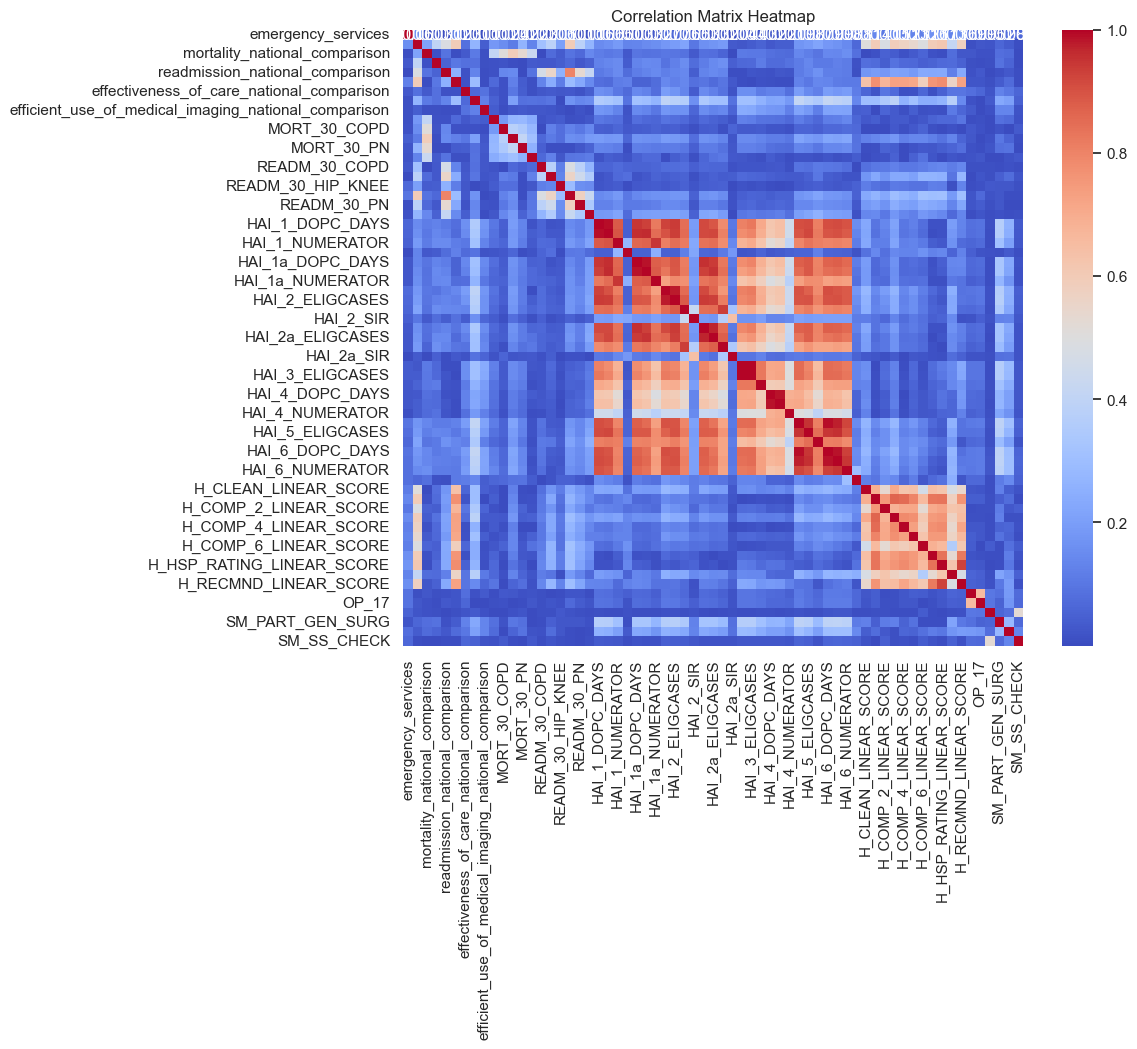

In [39]:
#Checking for correlation between columns
corr_matrix = base_df_cleaned.corr().abs()
#X_corr = X_corr[X_corr != 1]
#X_corr.sort_values(ascending=True, inplace=True)
# Create a set to track unique pairs
selected_columns = []

# Iterate over columns
for col in corr_matrix.columns:
    # Check if the column has a correlation less than 0.8 with all previously selected columns
    if all(corr_matrix[col][selected_columns] < 0.8):
        selected_columns.append(col)

print("Columns selected with correlation less than 0.8 between them:")
remove_columns = [col for col in base_df_cleaned.columns if col not in selected_columns]
print("Length of columns that are selected")
print(len(selected_columns))
print("Length of cols to be removed which has corr > 0.8")
print(len(remove_columns))

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [40]:
remove_columns

['READM_30_HOSP_WIDE',
 'HAI_1_ELIGCASES',
 'HAI_1_NUMERATOR',
 'HAI_1a_DOPC_DAYS',
 'HAI_1a_ELIGCASES',
 'HAI_1a_NUMERATOR',
 'HAI_2_DOPC_DAYS',
 'HAI_2_ELIGCASES',
 'HAI_2_NUMERATOR',
 'HAI_2a_DOPC_DAYS',
 'HAI_2a_ELIGCASES',
 'HAI_3_DOPC_DAYS',
 'HAI_3_ELIGCASES',
 'HAI_4_ELIGCASES',
 'HAI_5_DOPC_DAYS',
 'HAI_5_ELIGCASES',
 'HAI_5_NUMERATOR',
 'HAI_6_DOPC_DAYS',
 'HAI_6_ELIGCASES',
 'HAI_6_NUMERATOR',
 'H_COMP_3_LINEAR_SCORE',
 'H_COMP_4_LINEAR_SCORE',
 'H_COMP_7_LINEAR_SCORE',
 'H_HSP_RATING_LINEAR_SCORE']

In [41]:
#Remove the highly correlated features
base_df_cleaned = base_df_cleaned[selected_columns]

In [909]:
#Auto EDA
import sweetviz as sv
sweet_report = sv.analyze(base_df_cleaned)
sweet_report.show_html('sweet_report_base_df.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report_base_df.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [42]:
# Convert the target variable also to numeric
base_df_cleaned['hospital_overall_rating'] = base_df_cleaned['hospital_overall_rating'].astype(int)

#Function to calculate IV
def calculate_woe_iv(dataset, feature_b, target, target_categories):
    dataset[feature_b].replace([np.inf, -np.inf], np.nan, inplace=True)

    if dataset[feature_b].dtype in ['float64', 'int64'] and 'flag' not in feature_b.lower():
        dataset['feature'] = pd.qcut(dataset[feature_b], q=[0, .05, .1, .2, .4, .6, .8, 0.9, 0.95, 1],
                                     duplicates='drop', precision=0).values.add_categories(['Missing', 'Others'])
    else:
        dataset['feature'] = dataset[feature_b]

    dataset['feature'].fillna('Missing', inplace=True)

    lst = []
    num_rows = dataset.shape[0]

    val_list = dataset['feature'].unique()
    for val in val_list:
        occ_val = dataset[dataset['feature'] == val].count()['feature']
        if occ_val < 0.005 * num_rows:
            dataset['feature'] = np.where(dataset['feature'] == val, 'Others', dataset['feature'])

    val_list = dataset['feature'].unique()
    for val in val_list:
        row = {'Feature': feature_b, 'Value': val, 'All': dataset[dataset['feature'] == val].count()['feature']}
        for target_val in target_categories:
            row[f'Target_{target_val}'] = dataset[(dataset['feature'] == val) & (dataset[target] == target_val)].count()['feature']
        lst.append(row)

    dset = pd.DataFrame(lst)

    for target_val in target_categories:
        dset[f'Event_rate_{target_val}'] = dset[f'Target_{target_val}'] / dset['All']
        dset[f'Prop_{target_val}'] = dset[f'Target_{target_val}'] / dset[f'Target_{target_val}'].sum()

    dset['Prop'] = dset['All'] / dset['All'].sum()
    woe_columns = []
    for target_val in target_categories:
        good = f'Prop_Target_{target_val}'
        bad = f'Prop_Target_not_{target_val}'
        
        dset[good] = dset[f'Target_{target_val}'] / dset[f'Target_{target_val}'].sum()
        dset[bad] = (dset['All'] - dset[f'Target_{target_val}']) / (dset['All'].sum() - dset[f'Target_{target_val}'].sum())

        # Handle divide by zero by replacing zeros with a small value
        dset[good] = dset[good].replace(0, 1e-10)
        dset[bad] = dset[bad].replace(0, 1e-10)

        woe_column = f'WoE_{target_val}'
        dset[woe_column] = np.log(dset[good] / dset[bad]).replace({np.inf: 0, -np.inf: 0})
        woe_columns.append(woe_column)
                          
    for target_val in target_categories:
        event_rate_column = f'Event_rate_{target_val}'
        dset[event_rate_column] = dset[f'Target_{target_val}'] / dset['All']

    dset['IV_component'] = 0
    for woe_column in woe_columns:
        target_val = woe_column.split('_')[-1]
        dset['IV_component'] += (dset[f'Prop_Target_{target_val}'] - dset[f'Prop_Target_not_{target_val}']) * dset[woe_column]

    iv = dset['IV_component'].sum()

    dset = dset.sort_values(by='All', ascending=False)
    print(dset[['Value', 'Prop'] + [f'Event_rate_{target_val}' for target_val in target_categories]])
    return dset, iv

In [43]:
target = "hospital_overall_rating"
ignore_cols = []
ignore_cols.append(target)
feat_list = list(set(base_df_cleaned.columns) - set(ignore_cols))
iv_summ=[]
dset_summ = []
for feat in feat_list:
    print(feat)
    dset, iv = calculate_woe_iv(base_df_cleaned,feat ,target,[1,2,3,4,5])
    dset['Feature'] = feat
    iv_summ.append(iv)
    if feat == feat_list[0]:
        dset_summ= dset
    else:
        dset_summ = pd.concat([dset, dset_summ])
        #dest_summ = dset_summ.append(dset, ignore_index=True)
        
dset_summ.to_csv("Woe_table.csv")       
df_iv = pd.DataFrame(list(zip(iv_summ, feat_list)),
                 columns=['IV', 'Feature'])

df_iv.to_csv("IV_table.csv") 
#(dset['All'] - dset[f'Target_{target_val}']) / (dset['All'].sum() - dset[f'Target_{target_val}'].sum())

HAI_2_SIR
         Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
1   (0.4, 0.5]  0.257127      0.009595      0.071429      0.563966   
4   (0.1, 0.4]  0.200384      0.030096      0.238030      0.444596   
3  (-0.1, 0.1]  0.200110      0.016438      0.167123      0.524658   
2   (0.5, 0.7]  0.142818      0.044146      0.251440      0.433781   
5   (0.7, 0.9]  0.099781      0.049451      0.260989      0.456044   
0   (1.2, 5.1]  0.050164      0.103825      0.262295      0.415301   
6   (0.9, 1.2]  0.049616      0.077348      0.259669      0.370166   

   Event_rate_4  Event_rate_5  
1      0.325160      0.029851  
4      0.259918      0.027360  
3      0.250685      0.041096  
2      0.247601      0.023033  
5      0.211538      0.021978  
0      0.180328      0.038251  
6      0.259669      0.033149  
safety_of_care_national_comparison
         Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
1  (-2.0, 0.0]  0.779605      0.037975      0.210970      0.507736  

In [44]:
dset_summ[dset_summ['Feature'] == 'patient_experience_national_comparison']

,Feature,Value,All,Target_1,Target_2,Target_3,Target_4,Target_5,Event_rate_1,Prop_1,Event_rate_2,Prop_2,Event_rate_3,Prop_3,Event_rate_4,Prop_4,Event_rate_5,Prop_5,Prop,Prop_Target_1,Prop_Target_not_1,WoE_1,Prop_Target_2,Prop_Target_not_2,WoE_2,Prop_Target_3,Prop_Target_not_3,WoE_3,Prop_Target_4,Prop_Target_not_4,WoE_4,Prop_Target_5,Prop_Target_not_5,WoE_5,IV_component
0,patient_experience_national_comparison,"(-2.0, 0.0]",2513,117,648,1395,340,13,0.046558,1.0,0.257859,0.947368,0.555113,0.787246,0.135296,0.352697,0.005173,0.117117,0.688871,1.000000e+00,0.678561,0.387780,0.947368,0.629217,0.409211,0.787246,0.595949,0.278386,0.352697,0.809613,-0.830946,0.117117,0.706814,-1.797593,1.747800
1,patient_experience_national_comparison,"(0.0, 1.0]",1135,0,36,377,624,98,0.000000,0.0,0.031718,0.052632,0.332159,0.212754,0.549780,0.647303,0.086344,0.882883,0.311129,1.000000e-10,0.321439,-21.890902,0.052632,0.370783,-1.952300,0.212754,0.404051,-0.641405,0.647303,0.190387,1.223753,0.882883,0.293186,1.102384,8.989632


In [45]:
df_iv.sort_values(by = 'IV', ascending = False).head(10)

,IV,Feature
22,19.263167,H_COMP_1_LINEAR_SCORE
2,16.233771,H_RECMND_LINEAR_SCORE
31,11.166732,H_COMP_2_LINEAR_SCORE
18,10.737432,patient_experience_national_comparison
15,10.600759,H_COMP_5_LINEAR_SCORE
39,10.244376,H_CLEAN_LINEAR_SCORE
12,8.756030,READM_30_PN
3,8.660099,H_COMP_6_LINEAR_SCORE
20,8.380754,READM_30_HF
30,5.871420,H_QUIET_LINEAR_SCORE


In [46]:
#Feature selection using Information value. We can use features with IV >0.02 and ignore others
for i in df_iv[df_iv['IV'] <0.02].Feature:
    ignore_cols.append(i)
feat_list = list(set(base_df_cleaned.columns) - set(ignore_cols))
print(len(feat_list))
ignore_cols

34


['hospital_overall_rating',
 'OP_25',
 'OP_12',
 'SM_SS_CHECK',
 'OP_17',
 'emergency_services',
 'SM_PART_GEN_SURG',
 'SM_PART_NURSE']

In [47]:
#Removing the columns with least information value
feat_list.append('hospital_overall_rating')
base_df_cleaned = base_df_cleaned[feat_list]
base_df_cleaned.head()

,HAI_2_SIR,safety_of_care_national_comparison,H_RECMND_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,readmission_national_comparison,effectiveness_of_care_national_comparison,HAI_1_DOPC_DAYS,MORT_30_PN,READM_30_STK,HAI_4_NUMERATOR,READM_30_PN,HAI_1_SIR,HAI_2a_SIR,H_COMP_5_LINEAR_SCORE,efficient_use_of_medical_imaging_national_comparison,HAI_4_DOPC_DAYS,patient_experience_national_comparison,MORT_30_HF,READM_30_HF,mortality_national_comparison,H_COMP_1_LINEAR_SCORE,MORT_30_STK,feature,READM_30_COPD,READM_30_HIP_KNEE,HAI_3_NUMERATOR,HAI_2a_NUMERATOR,H_QUIET_LINEAR_SCORE,H_COMP_2_LINEAR_SCORE,timeliness_of_care_national_comparison,MORT_30_AMI,HAI_6_SIR,MORT_30_COPD,H_CLEAN_LINEAR_SCORE,hospital_overall_rating
provider_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10001,1.427000,1.0,90.000000,87.000000,0.0,0.0,7117.0,15.5,12.700000,0.000000,18.7,1.740000,2.307000,77.000000,0.0,154.000000,-1.0,12.4,21.4,0.0,90.000000,15.40000,"(82.0, 84.0]",21.1,5.100000,10.000000,18.000000,88.000000,92.00000,0.0,12.500000,0.787,9.3,84.000000,3
10005,0.456000,0.0,89.000000,88.000000,1.0,0.0,2786.0,20.8,13.400000,0.000000,16.4,1.062000,0.698000,80.000000,-1.0,43.000000,0.0,15.5,21.9,-1.0,91.000000,15.50000,"(82.0, 84.0]",18.0,5.700000,1.000000,3.000000,86.000000,94.00000,1.0,16.000000,0.405,7.6,83.000000,3
10006,0.641000,0.0,84.000000,83.000000,0.0,0.0,11159.0,18.2,12.000000,2.000000,17.9,0.341000,0.801000,78.000000,0.0,55.000000,-1.0,15.6,20.6,-1.0,91.000000,17.90000,"(82.0, 84.0]",19.8,5.000000,1.000000,10.000000,86.000000,94.00000,1.0,16.700000,0.513,7.1,83.000000,2
10007,0.000000,0.0,86.000000,86.000000,-1.0,0.0,48.0,18.8,12.700000,0.849448,17.3,0.538761,0.581494,82.000000,0.0,101.247928,0.0,14.4,21.1,0.0,91.000000,16.60000,"(88.0, 90.0]",19.9,4.610617,0.000000,0.000000,92.000000,96.00000,1.0,14.063503,0.000,9.3,89.000000,3
10008,0.477087,0.0,87.946667,86.840889,0.0,0.0,28.0,15.7,12.566949,0.849448,16.0,0.538761,0.581494,78.682963,0.0,101.247928,0.0,12.7,23.1,0.0,91.281481,14.92973,"(87.0, 88.0]",19.2,4.610617,3.140915,4.549882,82.902815,91.86163,1.0,14.063503,0.585,8.2,87.235852,3


# Lets looks at the top 10 features with high IV value

In [48]:
feat_imp = pd.read_csv("IV_table.csv")
feat_imp = feat_imp.sort_values(by=['IV'], ascending=False)
feat_imp.head(10)

,Unnamed: 0,IV,Feature
22,22,19.263167,H_COMP_1_LINEAR_SCORE
2,2,16.233771,H_RECMND_LINEAR_SCORE
31,31,11.166732,H_COMP_2_LINEAR_SCORE
18,18,10.737432,patient_experience_national_comparison
15,15,10.600759,H_COMP_5_LINEAR_SCORE
39,39,10.244376,H_CLEAN_LINEAR_SCORE
12,12,8.756030,READM_30_PN
3,3,8.660099,H_COMP_6_LINEAR_SCORE
20,20,8.380754,READM_30_HF
30,30,5.871420,H_QUIET_LINEAR_SCORE


# Multi collinearity Check using VIF score

In [51]:
#Multicollinearity check using VIF score
from statsmodels.stats.outliers_influence import variance_inflation_factor

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = base_df_cleaned[feat_list].select_dtypes(include=numerics)
#newdf = newdf[~newdf.isin([np.nan, np.inf, -np.inf]).any(1)]
#newdf.drop(['H_COMP_1_LINEAR_SCORE','STK_2','H_COMP_2_LINEAR_SCORE','H_RECMND_LINEAR_SCORE',
#newdf.drop(['H_CLEAN_LINEAR_SCORE','VTE_2',
#'STK_5','H_QUIET_LINEAR_SCORE','READM_30_AMI','H_COMP_5_LINEAR_SCORE','H_COMP_6_LINEAR_SCORE','OP_4','STK_10'],axis=1, inplace=True)

VIF             = pd.DataFrame()
VIF['feature']  = newdf.columns
VIF['VIF']      = [variance_inflation_factor(newdf.values, i) for i in range(newdf.shape[1])]
# take a look
VIF.sort_values(by='VIF', ascending = False)

,feature,VIF
20,H_COMP_1_LINEAR_SCORE,6694.630678
27,H_COMP_2_LINEAR_SCORE,4082.652644
2,H_RECMND_LINEAR_SCORE,1670.372497
3,H_COMP_6_LINEAR_SCORE,1352.712351
32,H_CLEAN_LINEAR_SCORE,1262.941501
13,H_COMP_5_LINEAR_SCORE,1252.914163
26,H_QUIET_LINEAR_SCORE,615.124800
22,READM_30_COPD,352.107437
18,READM_30_HF,349.479796
8,READM_30_STK,254.896147


In [52]:
VIF[VIF['VIF']>500]['feature']

2     H_RECMND_LINEAR_SCORE
3     H_COMP_6_LINEAR_SCORE
13    H_COMP_5_LINEAR_SCORE
20    H_COMP_1_LINEAR_SCORE
26     H_QUIET_LINEAR_SCORE
27    H_COMP_2_LINEAR_SCORE
32     H_CLEAN_LINEAR_SCORE
Name: feature, dtype: object

In [53]:
def bivariate_graphs(base1,targetcol,target_category):

    feat_imp = pd.read_csv("IV_table.csv")
    feat_imp = feat_imp[feat_imp['Feature'].isin(feat_list)]
    feat_imp = feat_imp.sort_values(by=['IV'], ascending=False)
    top_5_feats = list(feat_imp['Feature'].head(5))
    #top_5_feats.append(targetcol)
  
    
    for feat in top_5_feats:
        w , i = calculate_woe_iv(base1[[feat,targetcol]], feat, targetcol,target_category)
        fig = plt.figure()
        plt.rcParams["figure.figsize"] = (10, 2)
        width = .75 # width of a bar
        i_temp = w.head(5)
        i_temp['Proportion of given range'] = i_temp['Prop']
        i_temp[ 'Hospital Rating - 1'] = i_temp['Event_rate_1']
        i_temp[ 'Hospital Rating - 2'] = i_temp['Event_rate_2']
        i_temp[ 'Hospital Rating - 3'] = i_temp['Event_rate_3']
        i_temp[ 'Hospital Rating - 4'] = i_temp['Event_rate_4']
        i_temp[ 'Hospital Rating - 5'] = i_temp['Event_rate_5']
        i_temp[['Proportion of given range','Hospital Rating - 1','Hospital Rating - 2','Hospital Rating - 3','Hospital Rating - 4','Hospital Rating - 5']].plot(kind='bar', width = width )
        ax = plt.gca()
        plt.xlim([-width, len(i_temp['Value'])-width])
        ax.set_xticklabels(i_temp['Value'] )
        ax.set_title(str('Ratings distribution' + ' : ' + feat),fontsize = 20)

        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.7),fancybox=True, shadow=True, ncol=5,fontsize = 15)
        plt.xticks(fontsize=15, rotation=45)
        plt.yticks(fontsize=15)
        plt.show()

           Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
2   (91.0, 92.0]  0.257127      0.004264      0.103412      0.606610   
0   (88.0, 90.0]  0.190789      0.056034      0.347701      0.518678   
1   (90.0, 91.0]  0.169134      0.016207      0.186386      0.604538   
3   (92.0, 93.0]  0.143366      0.000000      0.057361      0.470363   
4   (93.0, 94.0]  0.074561      0.000000      0.007353      0.341912   
6   (75.0, 87.0]  0.058936      0.241860      0.534884      0.204651   
5   (87.0, 88.0]  0.042215      0.077922      0.538961      0.344156   
8   (94.0, 95.0]  0.038103      0.000000      0.000000      0.172662   
7  (95.0, 100.0]  0.025768      0.000000      0.000000      0.095745   

   Event_rate_4  Event_rate_5  
2      0.268657      0.017058  
0      0.077586      0.000000  
1      0.186386      0.006483  
3      0.422562      0.049713  
4      0.588235      0.062500  
6      0.018605      0.000000  
5      0.038961      0.000000  
8      0.676259      0.

<Figure size 1000x200 with 0 Axes>

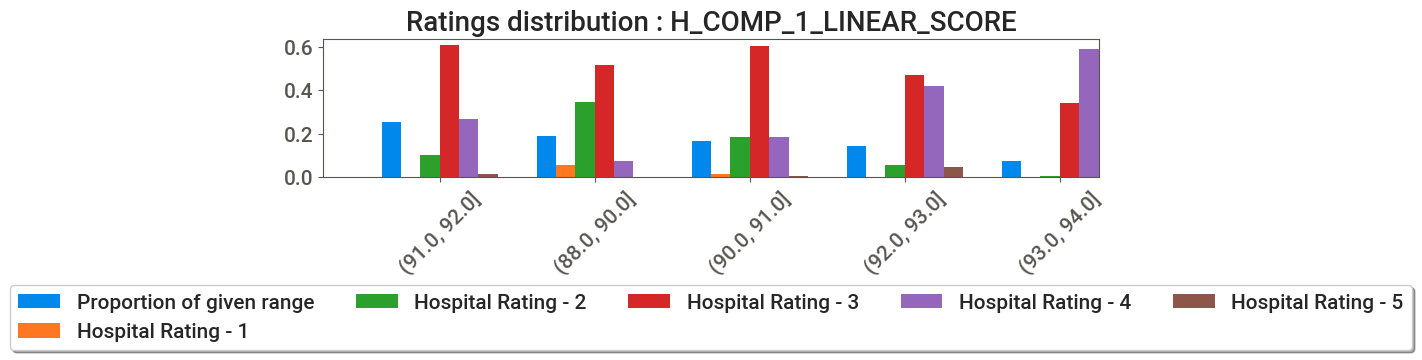

           Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
3   (85.0, 88.0]  0.224507      0.025641      0.196581      0.632479   
0   (89.0, 91.0]  0.182840      0.005997      0.086957      0.502249   
1   (88.0, 89.0]  0.171053      0.017628      0.142628      0.570513   
6   (91.0, 93.0]  0.119243      0.000000      0.041379      0.340230   
2   (83.0, 85.0]  0.106634      0.048843      0.339332      0.537275   
7   (81.0, 83.0]  0.067160      0.065306      0.424490      0.457143   
8   (58.0, 81.0]  0.064967      0.194093      0.514768      0.274262   
5  (94.0, 100.0]  0.032621      0.000000      0.000000      0.033613   
4   (93.0, 94.0]  0.030976      0.000000      0.000000      0.221239   

   Event_rate_4  Event_rate_5  
3      0.141636      0.003663  
0      0.389805      0.014993  
1      0.262821      0.006410  
6      0.558621      0.059770  
2      0.074550      0.000000  
7      0.053061      0.000000  
8      0.016878      0.000000  
5      0.537815      0.

<Figure size 1000x200 with 0 Axes>

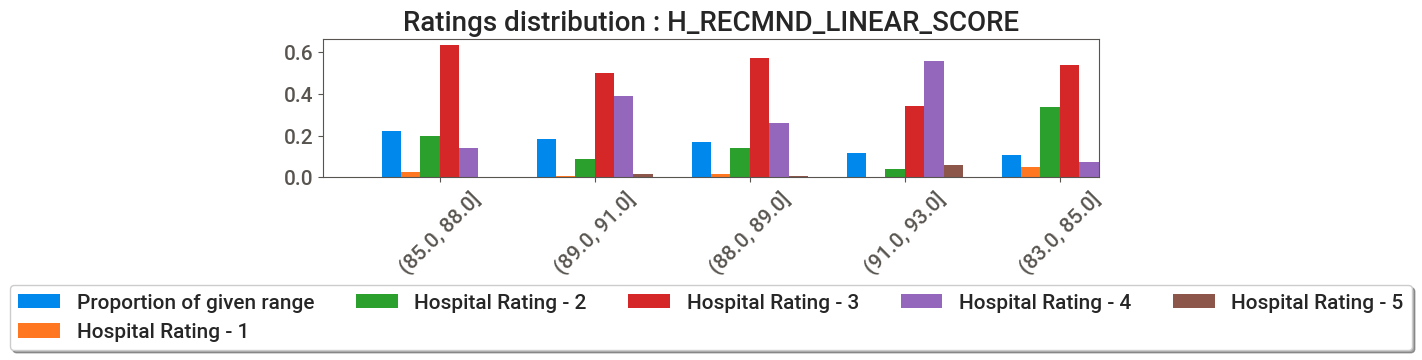

           Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
1   (92.0, 94.0]  0.240954      0.004551      0.075085      0.470990   
3   (90.0, 91.9]  0.226974      0.030193      0.189614      0.596618   
0   (91.9, 92.0]  0.180647      0.007587      0.150228      0.535660   
6   (89.0, 90.0]  0.106908      0.048718      0.325641      0.517949   
7   (88.0, 89.0]  0.067160      0.118367      0.400000      0.416327   
4   (94.0, 95.0]  0.062500      0.000000      0.021930      0.359649   
8   (77.9, 88.0]  0.062500      0.153509      0.552632      0.254386   
2   (95.0, 96.0]  0.030702      0.000000      0.035714      0.348214   
5  (96.0, 100.0]  0.021656      0.000000      0.025316      0.354430   

   Event_rate_4  Event_rate_5  
1      0.401593      0.047782  
3      0.173913      0.009662  
0      0.282246      0.024279  
6      0.107692      0.000000  
7      0.065306      0.000000  
4      0.478070      0.140351  
8      0.039474      0.000000  
2      0.517857      0.

<Figure size 1000x200 with 0 Axes>

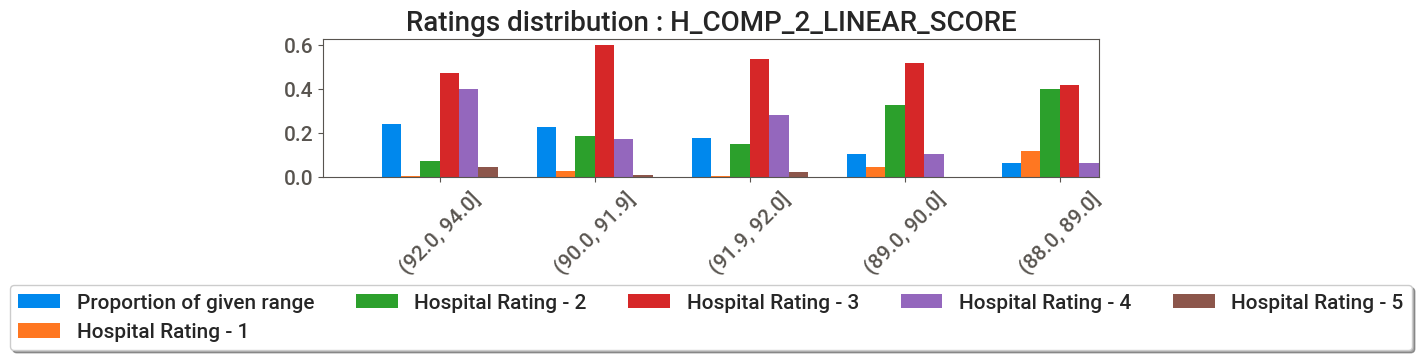

         Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
0  (-2.0, 0.0]  0.688871      0.046558      0.257859      0.555113   
1   (0.0, 1.0]  0.311129      0.000000      0.031718      0.332159   

   Event_rate_4  Event_rate_5  
0      0.135296      0.005173  
1      0.549780      0.086344  


<Figure size 1000x200 with 0 Axes>

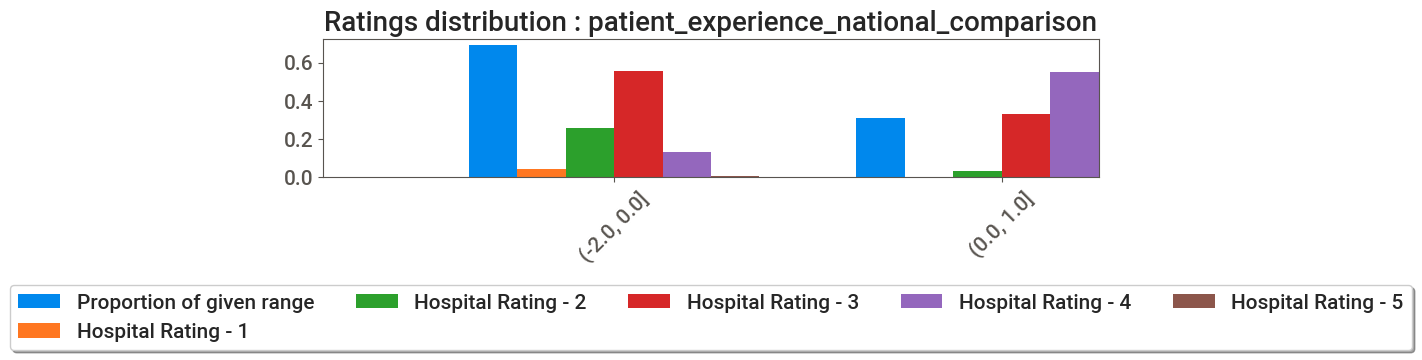

          Value      Prop  Event_rate_1  Event_rate_2  Event_rate_3  \
1  (79.0, 82.0]  0.230811      0.003563      0.068884      0.492874   
0  (76.0, 78.0]  0.189693      0.018786      0.221098      0.560694   
2  (78.0, 79.0]  0.172971      0.014263      0.134707      0.637084   
4  (74.0, 76.0]  0.130208      0.040000      0.328421      0.522105   
7  (82.0, 84.0]  0.080592      0.000000      0.034014      0.414966   
3  (72.0, 74.0]  0.064693      0.144068      0.402542      0.402542   
5  (57.0, 72.0]  0.060581      0.176471      0.561086      0.230769   
6  (85.0, 94.0]  0.047971      0.000000      0.005714      0.160000   
8  (84.0, 85.0]  0.022478      0.000000      0.024390      0.280488   

   Event_rate_4  Event_rate_5  
1      0.394299      0.040380  
0      0.193642      0.005780  
2      0.199683      0.014263  
4      0.098947      0.010526  
7      0.479592      0.071429  
3      0.050847      0.000000  
5      0.031674      0.000000  
6      0.668571      0.165714  
8

<Figure size 1000x200 with 0 Axes>

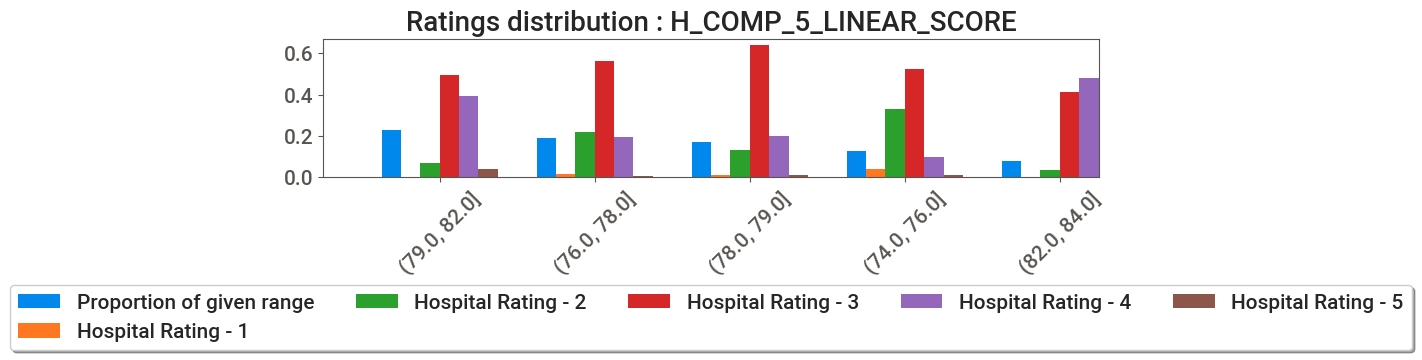

In [918]:
import warnings
warnings.simplefilter(action='ignore')

bivariate_graphs(base_df_cleaned,target,[1,2,3,4,5])

## Key Findings

- When the Nurse  Communication Linear mean score is in the range 92 -94, the hospitals are getting rating 4 and above but most of the score lies in
between 88-91 causing more ratings to be 2 and 3
- When the ‘Catheter-Associated Urinary Tract Infections (CAUTI) in ICUs only’ score is less i.e., in the range of 0.28-0.47, the hospitals are getting top ratings.
- When the Recommend Hospital Linear mean score is higher the hospital ratings are above 3
- When we see the rate of admission for stroke patients  in last 30 days is less i.e., in the range 11.9 – 12.3, the hospital ratings tend to be high



# Skewness Treatment

In [54]:
# Function to classify columns based on skewness
def classify_skewness(df):
    skewed_right = []
    skewed_left = []

    numeric_columns = base_df_cleaned.select_dtypes(include=['float64', 'int64']).columns
    filtered_columns = [col for col in numeric_columns if col not in categorical_cols]
    for col in filtered_columns:
        skewness = df[col].skew()
        if skewness > 0.5:  # You can adjust the threshold as needed
            skewed_right.append(col)
        elif skewness < -0.5:
            skewed_left.append(col)

    return skewed_right, skewed_left

# Get lists of right-skewed and left-skewed columns
right_skewed_columns, left_skewed_columns = classify_skewness(base_df_cleaned)

print(f'Right-skewed columns: {right_skewed_columns}')
print(f'Left-skewed columns: {left_skewed_columns}')

Right-skewed columns: ['HAI_2_SIR', 'HAI_1_DOPC_DAYS', 'READM_30_STK', 'HAI_4_NUMERATOR', 'READM_30_PN', 'HAI_1_SIR', 'HAI_2a_SIR', 'HAI_4_DOPC_DAYS', 'READM_30_HIP_KNEE', 'HAI_3_NUMERATOR', 'HAI_2a_NUMERATOR', 'HAI_6_SIR', 'MORT_30_COPD']
Left-skewed columns: ['H_RECMND_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE']


In [55]:
# Treat Skewness
def treat_skewness(df, skewed_right, skewed_left):
    for col in skewed_right:
        # Apply log transformation
        df[col] = np.log1p(df[col])  # log1p is log(1 + x) to handle zero values

    for col in skewed_left:
        # Apply square root transformation for negative skewness
        df[col] = np.sqrt(df[col].max() - df[col])

    return df
base_df_cleaned = treat_skewness(base_df_cleaned, right_skewed_columns, left_skewed_columns)

# Check skewness after treatment
right_skewed_columns, left_skewed_columns = classify_skewness(base_df_cleaned)

print(f'Right-skewed columns after transformation: {right_skewed_columns}')
print(f'Left-skewed columns after transformation: {left_skewed_columns}')

Right-skewed columns after transformation: ['HAI_4_NUMERATOR', 'HAI_1_SIR', 'HAI_2a_NUMERATOR']
Left-skewed columns after transformation: ['HAI_1_DOPC_DAYS', 'HAI_4_DOPC_DAYS']


# Outlier treatment

In [56]:
#Outlier detection
def detect_outliers(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    newdf = df[feat_list].select_dtypes(include=numerics)
    Outlier_list = []
    for col in newdf.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        fence_low = q1 - 1.5*iqr
        fence_high = q3 +1.5*iqr
        #Outlier['col'] = col
        Outlier_list.append({'Col':col, 'Count':df.loc[(df[col] < fence_low) | (df[col] > fence_high)].shape[0], 'Fence low':fence_low, 'Fence high':fence_high})
    Outlier = pd.DataFrame(Outlier_list)
    Outlier = Outlier.sort_values(by = 'Count', ascending = False)
    print(Outlier)
    return Outlier
        #print(col + ' -- ', "Outliers count: ", df.loc[(df[col] < fence_low) | (df[col] > fence_high)].shape[0],"fence low : ",fence_low,"fence high : ",fence_high)
Outlier = detect_outliers(base_df_cleaned)

                                                  Col  Count  Fence low  \
4                     readmission_national_comparison   1671   0.000000   
1                  safety_of_care_national_comparison   1477   0.000000   
12                                         HAI_2a_SIR    911   0.106474   
11                                          HAI_1_SIR    779   0.093331   
19                      mortality_national_comparison    745   0.000000   
14  efficient_use_of_medical_imaging_national_comp...    727   0.000000   
29                                        MORT_30_AMI    559  12.587500   
8                                        READM_30_STK    434   2.494528   
30                                          HAI_6_SIR    364   0.028276   
23                                  READM_30_HIP_KNEE    362   1.579211   
21                                        MORT_30_STK    304  12.250000   
27                              H_COMP_2_LINEAR_SCORE    200  88.000000   
9                        

# Data Modelling

In [1037]:
final_df = base_df_cleaned.copy()
final_df.reset_index(inplace=True)
final_df.head()

,provider_id,STK_8,PSI_6_IAT_PTX,READM_30_HF,MORT_30_STK,HAI_4_DOPC_DAYS,H_CLEAN_LINEAR_SCORE,PSI_14_POSTOP_DEHIS,MORT_30_AMI,H_COMP_2_LINEAR_SCORE,safety_of_care_national_comparison,PAYM_30_PN,OP_18b,READM_30_STK,PSI_12_POSTOP_PULMEMB_DVT,PSI_13_POST_SEPSIS,COMP_HIP_KNEE,OP_11,ED_1b,HAI_1_SIR,OP_10,OP_20,VTE_1,READM_30_HIP_KNEE,PSI_15_ACC_LAC,OP_29,PAYM_30_AMI,PC_01,VTE_2,HAI_1_DOPC_DAYS,OP_22,VTE_3,timeliness_of_care_national_comparison,PSI_3_ULCER,HAI_6_SIR,HAI_4_NUMERATOR,mortality_national_comparison,OP_30,readmission_national_comparison,IMM_3_OP_27_FAC_ADHPCT,OP_14,PSI_7_CVCBI,H_QUIET_LINEAR_SCORE,EDV,H_COMP_5_LINEAR_SCORE,OP_13,patient_experience_national_comparison,HAI_2a_NUMERATOR,STK_1,READM_30_PN,effectiveness_of_care_national_comparison,H_COMP_1_LINEAR_SCORE,efficient_use_of_medical_imaging_national_comparison,MORT_30_PN,PAYM_30_HF,OP_21,HAI_2a_SIR,READM_30_COPD,H_RECMND_LINEAR_SCORE,H_COMP_6_LINEAR_SCORE,MORT_30_COPD,STK_6,VTE_5,OP_9,feature,HAI_2_SIR,IMM_2,HAI_3_NUMERATOR,MORT_30_HF,hospital_overall_rating
0,10001,3.605551,0.307485,21.4,15.40000,5.043425,84.000000,1.313724,12.500000,92.00000,1.0,15.089,5.283204,2.617396,1.463255,1.905088,1.568616,0.641854,5.598422,1.007958,2.001480,4.189655,1.732051,1.808289,0.854415,5.212638,21.804000,0.000000,1.000000,8.870382,1.609438,3.000000,0.0,0.067659,0.580538,0.000000,0.0,4.242641,0.0,4.358899,1.223775,0.113329,88.000000,3.0,77.000000,2.091864,-1.0,2.944439,1.000000,2.980619,0.0,3.162278,0.0,15.5,15.659,4.605170,1.196041,21.1,3.162278,3.464102,2.332144,1.000000,3.162278,2.066863,"(126.0, 230.0]",0.886656,1.732051,2.397895,12.4,3
1,10005,0.000000,0.385262,21.9,15.50000,3.784190,83.000000,1.134623,16.000000,94.00000,0.0,14.384,4.770685,2.667228,1.891605,2.320425,1.386294,2.415914,5.497168,0.723676,2.660260,3.332205,2.236068,1.902108,0.810930,2.828427,23.171000,0.693147,2.449490,7.932721,1.098612,0.000000,1.0,0.131028,0.340037,0.000000,-1.0,2.828427,1.0,4.123106,1.609438,0.104360,86.000000,4.0,80.000000,1.840550,0.0,1.386294,1.414214,2.856470,0.0,3.000000,-1.0,20.8,16.376,4.110874,0.529451,18.0,3.316625,3.316625,2.151762,3.464102,0.000000,1.808289,"(15.0, 47.0]",0.375693,1.000000,0.693147,15.5,3
2,10006,3.162278,0.343590,20.6,17.90000,4.025352,83.000000,1.252763,16.700000,94.00000,0.0,15.066,4.897840,2.564949,1.578979,2.420727,1.568616,1.722767,5.384495,0.293416,2.549445,2.397895,1.414214,1.791759,1.075002,5.477226,20.946000,0.000000,3.316625,9.320091,0.693147,3.741657,1.0,0.086178,0.414094,1.098612,-1.0,3.464102,0.0,3.605551,1.722767,0.215111,86.000000,3.0,78.000000,0.000000,-1.0,2.397895,1.000000,2.939162,0.0,3.000000,0.0,18.2,14.880,4.077537,0.588342,19.8,4.000000,4.000000,2.091864,1.732051,2.828427,2.312535,"(47.0, 101.0]",0.495306,0.000000,0.693147,15.6,2
3,10007,2.577558,0.336472,21.1,16.60000,4.627401,89.000000,1.199650,14.063503,96.00000,0.0,12.844,4.787492,2.617396,1.717395,2.387845,1.397243,1.960095,5.393628,0.430978,3.230804,3.663562,1.732051,1.724661,0.788457,10.000000,22.970923,1.236921,1.000000,3.891820,0.693147,2.602096,1.0,0.300105,0.000000,0.614887,0.0,10.000000,-1.0,6.855655,1.353558,0.148420,92.000000,1.0,82.000000,1.737790,0.0,0.000000,4.472136,2.906901,0.0,3.000000,0.0,18.8,13.676,4.510860,0.458370,19.9,3.741657,3.605551,2.332144,5.385165,2.678683,3.077312,"(47.0, 101.0]",0.000000,1.000000,0.000000,14.4,3
4,10008,2.577558,0.343590,23.1,14.92973,4.627401,87.235852,1.199650,14.063503,91.86163,0.0,14.482,4.595120,2.607637,1.799261,2.420727,1.397243,1.408111,5.198497,0.430978,1.526056,3.332205,1.000000,1.724661,0.879627,2.000000,22.970923,1.236921,1.786125,3.367296,0.693147,2.602096,1.0,0.371564,0.460584,0.614887,0.0,1.732051,0.0,7.549834,0.470004,0.157004,82.902815,1.0,78.682963,1.737790,0.0,1.713777,1.870526,2.833213,0.0,2.952714,0.0,15.7,15.274,3.912023,0.458370,19.2,3.471791,3.486992,2.219203,2.129820,2.678683,2.219203,"(47.0, 101.0]",0.390072,2.236068,1.420917,12.7,3


In [1038]:
final_df.drop(['feature'], axis =1, inplace= True)
final_df.dropna(inplace=True)
final_df['hospital_overall_rating'] = final_df['hospital_overall_rating'].astype('category')

#Separating Evanston Hospital into final test data for prediction
final_test = final_df[final_df['provider_id']==140010]
final_test = final_df.drop(['hospital_overall_rating','provider_id'],axis =1)
#Separating the target variable
X = final_df.drop(['hospital_overall_rating','provider_id'],axis =1)
y = final_df['hospital_overall_rating']

#Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)


In [1039]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
numeric_cols = X.select_dtypes(include=['number']).columns

scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_train.shape

(2553, 67)

## Logistic Regression

In [1017]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import model_selection, tree, ensemble, metrics
lr = LogisticRegression(random_state= 0, multi_class = 'ovr')
lr.fit(X_train,y_train)
print("Train score :")
print(lr.score(X_train,y_train))

#X_test.drop(remaining_columns, axis = 1, inplace = True)
#col = X_train.columns
pred = lr.predict(X_test)

# Calculate precision, recall, and f1-score
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

# Calculate AUC-ROC score
# Note: For multi-class, use the 'ovr' strategy
y_prob = lr.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred))

# Print the calculated metrics
print(f"Accuracy: {lr.score(X_test,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

Train score :
0.754406580493537
Test score :
0.7022831050228311
Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.11      0.20        37
           2       0.71      0.45      0.55       235
           3       0.69      0.89      0.78       513
           4       0.72      0.72      0.72       275
           5       1.00      0.06      0.11        35

    accuracy                           0.70      1095
   macro avg       0.82      0.45      0.47      1095
weighted avg       0.72      0.70      0.67      1095

Confusion Matrix:
[[  4  32   1   0   0]
 [  0 106 129   0   0]
 [  0  11 458  44   0]
 [  0   0  76 199   0]
 [  0   0   1  32   2]]
Accuracy: 0.7022831050228311
Precision: 0.7228269349479242
Recall: 0.7022831050228311
F1-Score: 0.6745626530764297
AUC-ROC: 0.8974046739208101


## Smote Sampling 

In [1040]:
from sklearn.model_selection import GridSearchCV
# Using Smote sampling as the target variable has imbalanced data
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
# Hyperparameter tuning using GridSearchCV
parameters = {'penalty' : ['l1','l2'], 'C' : [0.001,0.01,0.1,1,10,100,1000]}
clf = GridSearchCV(LogisticRegression(), parameters, verbose = 2)
clf.fit(X_train_sm, y_train_sm)
clf.best_score_

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l1; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.1s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END ................................C=0.001, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01

0.8808578236695791

In [936]:
lr_best = clf.best_estimator_
lr_best

LogisticRegression(C=100)

In [1020]:
pred_lr = lr_best.predict(X_test)
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, pred_lr, average='weighted')
recall = recall_score(y_test, pred_lr, average='weighted')
f1 = f1_score(y_test, pred_lr, average='weighted')

# Calculate AUC-ROC score
y_prob = lr_best.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, pred_lr))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_lr))

# Print the calculated metrics
print(f"Accuracy: {lr_best.score(X_test,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.62      0.55        37
           2       0.79      0.79      0.79       235
           3       0.86      0.79      0.82       513
           4       0.73      0.80      0.76       275
           5       0.57      0.74      0.64        35

    accuracy                           0.78      1095
   macro avg       0.69      0.75      0.71      1095
weighted avg       0.79      0.78      0.79      1095

Confusion Matrix:
[[ 23  14   0   0   0]
 [ 23 185  27   0   0]
 [  0  36 403  73   1]
 [  0   0  36 220  19]
 [  0   0   1   8  26]]
Accuracy: 0.782648401826484
Precision: 0.7917581898758282
Recall: 0.782648401826484
F1-Score: 0.785352448286677
AUC-ROC: 0.9370437038885735


In [938]:
lr_best.predict_proba(X_test)

array([[4.34061741e-07, 5.59418183e-02, 8.98898578e-01, 4.51591696e-02,
        2.77976357e-10],
       [1.15155474e-04, 6.90129875e-01, 3.09696336e-01, 5.86337403e-05,
        1.16429298e-21],
       [4.10377869e-12, 1.59223904e-03, 8.89928595e-01, 1.08479166e-01,
        4.17817149e-11],
       ...,
       [3.04996723e-05, 4.08531993e-01, 5.90650539e-01, 7.86968544e-04,
        5.99868858e-16],
       [7.62731139e-19, 4.91947839e-09, 5.02949482e-03, 9.61634824e-01,
        3.33356767e-02],
       [6.42682005e-11, 2.67243116e-04, 5.16355842e-01, 4.83347330e-01,
        2.95852067e-05]])

# Feature Selection using RFE

In [1041]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=lr, n_features_to_select=15)
rfe = rfe.fit(X_train_sm,y_train_sm)
rfe

RFE(estimator=LogisticRegression(multi_class='ovr', random_state=0),
    n_features_to_select=15)

In [1042]:
# Get the selected features
selected_features = X_train_sm.columns[rfe.support_]

print("Selected Features:", selected_features)

Selected Features: Index(['READM_30_HF', 'MORT_30_STK', 'PSI_12_POSTOP_PULMEMB_DVT',
       'COMP_HIP_KNEE', 'ED_1b', 'VTE_1', 'PSI_15_ACC_LAC', 'PSI_3_ULCER',
       'readmission_national_comparison', 'H_COMP_5_LINEAR_SCORE',
       'H_COMP_1_LINEAR_SCORE', 'MORT_30_PN', 'READM_30_COPD',
       'H_RECMND_LINEAR_SCORE', 'MORT_30_HF'],
      dtype='object')


In [1043]:
col = X_train_sm.columns[rfe.support_]
X_train_rfe = X_train_sm[col]
X_test_rfe = X_test[col]

## Decision Tree Classifier

In [1023]:
from sklearn.tree import DecisionTreeClassifier
dt_base = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_base.fit(X_train_rfe, y_train_sm)
y_train_pred = dt_base.predict(X_train_rfe)
col = X_train_sm.columns
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
y_test_pred = dt_base.predict(X_test_rfe)
print("Train Score")
print(dt_base.score(X_train_rfe,y_train_sm))

# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Calculate AUC-ROC score
y_prob = dt_base.predict_proba(X_test_rfe)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the calculated metrics
print(f"Accuracy: {dt_base.score(X_test_rfe,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

Train Score
0.67736298649722
Test Score
0.5050228310502283
Classification Report:
              precision    recall  f1-score   support

           1       0.31      0.59      0.41        37
           2       0.52      0.54      0.53       235
           3       0.67      0.40      0.50       513
           4       0.43      0.64      0.52       275
           5       0.34      0.71      0.46        35

    accuracy                           0.51      1095
   macro avg       0.46      0.58      0.48      1095
weighted avg       0.56      0.51      0.51      1095

Confusion Matrix:
[[ 22  14   1   0   0]
 [ 37 126  54  18   0]
 [ 11  86 204 203   9]
 [  0  16  44 176  39]
 [  0   0   2   8  25]]
Accuracy: 0.5050228310502283
Precision: 0.555797012798335
Recall: 0.5050228310502283
F1-Score: 0.5057492257380143
AUC-ROC: 0.7509361410859469


# Hyper parameter tuning using Grid Search

In [948]:
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
params = {
    "max_depth": [2,3,5,10,20],
    "min_samples_leaf": [5,10,20,50,100,500]
}
grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(X_train_rfe, y_train_sm)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 500]},
             scoring='accuracy', verbose=1)

In [949]:
grid_search.best_score_

0.7828460092523856

In [950]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=42)

In [951]:
y_pred = dt_best.predict(X_test_rfe)
# Evaluate the model
print(dt_base.score(X_test_rfe,y_test))
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Calculate AUC-ROC score
y_prob = dt_base.predict_proba(X_test_rfe)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the calculated metrics
print(f"Accuracy: {dt_base.score(X_test_rfe,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

0.5050228310502283
Confusion Matrix:
[[ 18  17   2   0   0]
 [ 24 136  70   5   0]
 [  4  66 340 100   3]
 [  0   4  98 154  19]
 [  0   0   2  12  21]]
Classification Report:
              precision    recall  f1-score   support

           1       0.39      0.49      0.43        37
           2       0.61      0.58      0.59       235
           3       0.66      0.66      0.66       513
           4       0.57      0.56      0.56       275
           5       0.49      0.60      0.54        35

    accuracy                           0.61      1095
   macro avg       0.54      0.58      0.56      1095
weighted avg       0.61      0.61      0.61      1095



# Random Forest Classifier

In [1033]:
rf = RandomForestClassifier(max_depth=3,max_features=5,random_state=42,oob_score=True)
rf.fit(X_train_sm,y_train_sm)

RandomForestClassifier(max_depth=3, max_features=5, oob_score=True,
                       random_state=42)

In [1034]:
rf.oob_score_

0.6792692613185067

In [1035]:
y_pred = rf.predict(X_test)

In [1036]:
# Evaluate the model
print(rf.score(X_test,y_test))
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate AUC-ROC score
y_prob = dt_base.predict_proba(X_test_rfe)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the calculated metrics
print(f"Accuracy: {rf.score(X_test,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

0.0319634703196347
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        37
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       513
           4       0.00      0.00      0.00       275
           5       0.03      1.00      0.06        35

    accuracy                           0.03      1095
   macro avg       0.01      0.20      0.01      1095
weighted avg       0.00      0.03      0.00      1095

Confusion Matrix:
[[  0   0   0   0  37]
 [  0   0   0   0 235]
 [  0   0   0   0 513]
 [  0   0   0   0 275]
 [  0   0   0   0  35]]
Accuracy: 0.0319634703196347
Precision: 0.0010216634348741685
Recall: 0.0319634703196347
F1-Score: 0.0019800379844021492
AUC-ROC: 0.7509361410859469


# HyperParameter tuning using Random Forest

In [1055]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [1056]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10, 25, 50, 100]
}
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)
grid_search.best_score_

Fitting 4 folds for each of 120 candidates, totalling 480 fits


0.7168062362331424

In [1057]:
rf_best = grid_search.best_estimator_
rf_best
RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

In [1058]:
# Evaluate the model
print(rf_best.score(X_test,y_test))
# Evaluate the model
print(dt_base.score(X_test_rfe,y_test))
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

# Calculate AUC-ROC score
y_prob = dt_base.predict_proba(X_test_rfe)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Print the calculated metrics
print(f"Accuracy: {rf_best.score(X_test,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

0.7068493150684931
0.5050228310502283
Classification Report:
              precision    recall  f1-score   support

           1       0.31      0.59      0.41        37
           2       0.52      0.54      0.53       235
           3       0.67      0.40      0.50       513
           4       0.43      0.64      0.52       275
           5       0.34      0.71      0.46        35

    accuracy                           0.51      1095
   macro avg       0.46      0.58      0.48      1095
weighted avg       0.56      0.51      0.51      1095

Confusion Matrix:
[[ 22  14   1   0   0]
 [ 37 126  54  18   0]
 [ 11  86 204 203   9]
 [  0  16  44 176  39]
 [  0   0   2   8  25]]
Accuracy: 0.7068493150684931
Precision: 0.555797012798335
Recall: 0.5050228310502283
F1-Score: 0.5057492257380143
AUC-ROC: 0.7509361410859469


# Gradient Boosting Classifier

In [1053]:
from sklearn.ensemble import GradientBoostingClassifier

gradboost = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0
)
gradboost.fit(X_train_sm, y_train_sm)
y_train_pred = gradboost.predict(X_train)
print("Train scores")
accuracy_score(y_train, y_train_pred)

y_test_pred_xg = gradboost.predict(X_test)

# Evaluate the model
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_test_pred_xg, average='weighted')
recall = recall_score(y_test, y_test_pred_xg, average='weighted')
f1 = f1_score(y_test, y_test_pred_xg, average='weighted')

# Calculate AUC-ROC score
y_prob = gradboost.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_xg))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_xg))

# Print the calculated metrics
print(f"Accuracy: {gradboost.score(X_test,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

Train scores
Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.41      0.44        37
           2       0.77      0.69      0.73       235
           3       0.78      0.83      0.81       513
           4       0.73      0.74      0.74       275
           5       0.66      0.54      0.59        35

    accuracy                           0.76      1095
   macro avg       0.68      0.64      0.66      1095
weighted avg       0.75      0.76      0.75      1095

Confusion Matrix:
[[ 15  22   0   0   0]
 [ 16 162  57   0   0]
 [  0  27 428  58   0]
 [  0   0  61 204  10]
 [  0   0   0  16  19]]
Accuracy: 0.7561643835616438
Precision: 0.7535992966726189
Recall: 0.7561643835616438
F1-Score: 0.7537702894446019
AUC-ROC: 0.904992388361739


In [1050]:
y_test_pred_xg = gradboost.predict(X_test)
print(accuracy_score(y_test, y_test_pred_xg))
cm = confusion_matrix(y_test, y_test_pred_xg)
print(classification_report(y_test, y_test_pred_xg))

0.7561643835616438
              precision    recall  f1-score   support

           1       0.48      0.41      0.44        37
           2       0.77      0.69      0.73       235
           3       0.78      0.83      0.81       513
           4       0.73      0.74      0.74       275
           5       0.66      0.54      0.59        35

    accuracy                           0.76      1095
   macro avg       0.68      0.64      0.66      1095
weighted avg       0.75      0.76      0.75      1095



## Gradient Boost with selected features from RFE

In [1051]:
gradboost_rfe = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.6,
    max_depth=3,
    subsample=0.8,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42
)
gradboost_rfe.fit(X_train_rfe, y_train_sm)
y_train_pred = gradboost_rfe.predict(X_train_rfe)
print("Training data scores")
print(accuracy_score(y_train_sm, y_train_pred))
cm = confusion_matrix(y_train_sm, y_train_pred)
print(classification_report(y_train_sm, y_train_pred))

y_test_pred_xg = gradboost_rfe.predict(X_test_rfe)

# Evaluate the model
# Calculate precision, recall, and f1-score
precision = precision_score(y_test, y_test_pred_xg, average='weighted')
recall = recall_score(y_test, y_test_pred_xg, average='weighted')
f1 = f1_score(y_test, y_test_pred_xg, average='weighted')

# Calculate AUC-ROC score
y_prob = dt_base.predict_proba(X_test_rfe)
auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred_xg))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_xg))

# Print the calculated metrics
print(f"Accuracy: {gradboost_rfe.score(X_test_rfe,y_test)}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {auc}")

Training data scores
0.9998411437648927
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1259
           2       1.00      1.00      1.00      1259
           3       1.00      1.00      1.00      1259
           4       1.00      1.00      1.00      1259
           5       1.00      1.00      1.00      1259

    accuracy                           1.00      6295
   macro avg       1.00      1.00      1.00      6295
weighted avg       1.00      1.00      1.00      6295

Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.65      0.61        37
           2       0.78      0.71      0.74       235
           3       0.79      0.81      0.80       513
           4       0.73      0.76      0.74       275
           5       0.73      0.54      0.62        35

    accuracy                           0.76      1095
   macro avg       0.72      0.69      0.70      1095
weighted avg  

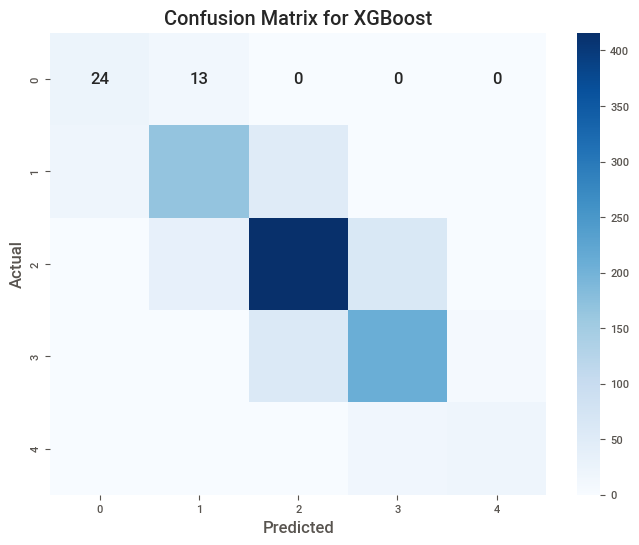

In [1013]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_test_pred_xg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()

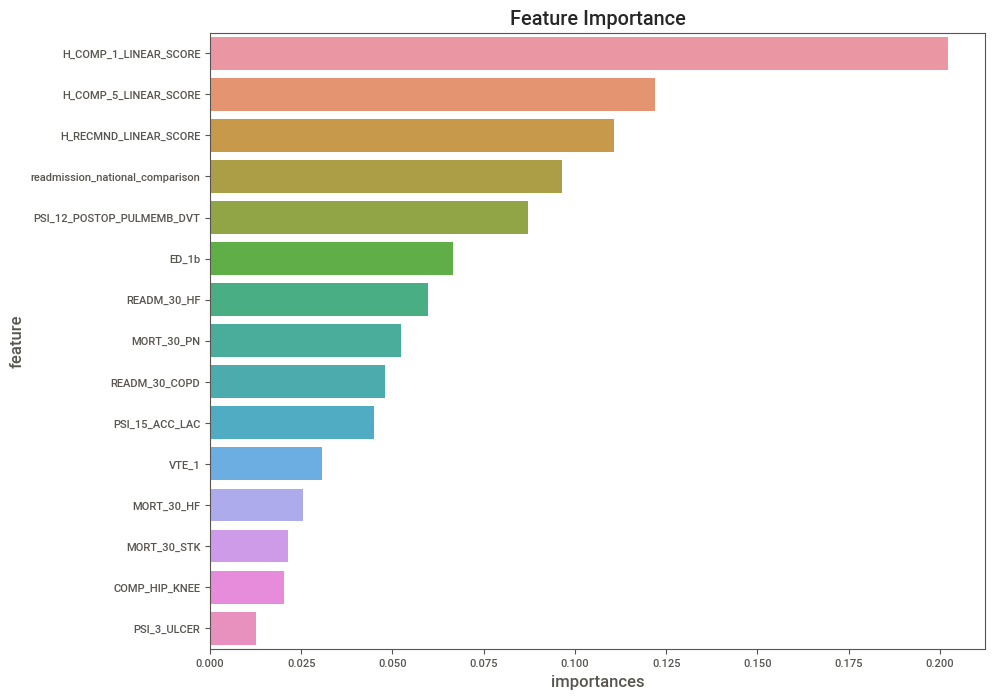

In [1066]:
# Feature importance
df = pd.DataFrame()
df['importances'] = gradboost_rfe.feature_importances_
df['feature'] = X_train_rfe.columns
df = df.sort_values(by='importances', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x=df['importances'], y=df['feature'])
plt.title('Feature Importance')
plt.show()

# Final test data Prediction 

Though Logistic regression using hyperparameter tuning and SMOTE sampling is givng the best accuracy score and AUC score. Gradient Boosting with RFE is giving optimal performance when classification report is checked. Hence will be predicting the final test data using Gradeint Boosting

In [994]:
final_test = final_test[col]
final_pred = gradboost_rfe.predict(final_test)
print(final_pred)

[1 1 1 ... 1 1 1]


The Hospital star rating based on the measures and the measure scores given is coming up as 1. So Evanston hospital needs to concentrate on the below measure to improve their rating

In [996]:
print(col)

Index(['READM_30_HF', 'MORT_30_STK', 'PSI_12_POSTOP_PULMEMB_DVT',
       'COMP_HIP_KNEE', 'ED_1b', 'VTE_1', 'PSI_15_ACC_LAC', 'PSI_3_ULCER',
       'readmission_national_comparison', 'H_COMP_5_LINEAR_SCORE',
       'H_COMP_1_LINEAR_SCORE', 'MORT_30_PN', 'READM_30_COPD',
       'H_RECMND_LINEAR_SCORE', 'MORT_30_HF'],
      dtype='object')


### Conclusion:
The measures which the hospital needs to conscentrate on improving are 'READM_30_HF', 'MORT_30_STK', 'PSI_12_POSTOP_PULMEMB_DVT',
       'COMP_HIP_KNEE', 'ED_1b', 'VTE_1', 'PSI_15_ACC_LAC', 'PSI_3_ULCER',
       'readmission_national_comparison', 'H_COMP_5_LINEAR_SCORE',
       'H_COMP_1_LINEAR_SCORE', 'MORT_30_PN', 'READM_30_COPD',
       'H_RECMND_LINEAR_SCORE', 'MORT_30_HF'. This will help improve their hospital star rating and improve their revenue.